In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br

from pycbc import conversions as conv

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
from scipy import integrate
import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter
import pycbc.filter as fil

from pycbc import types, fft, waveform

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


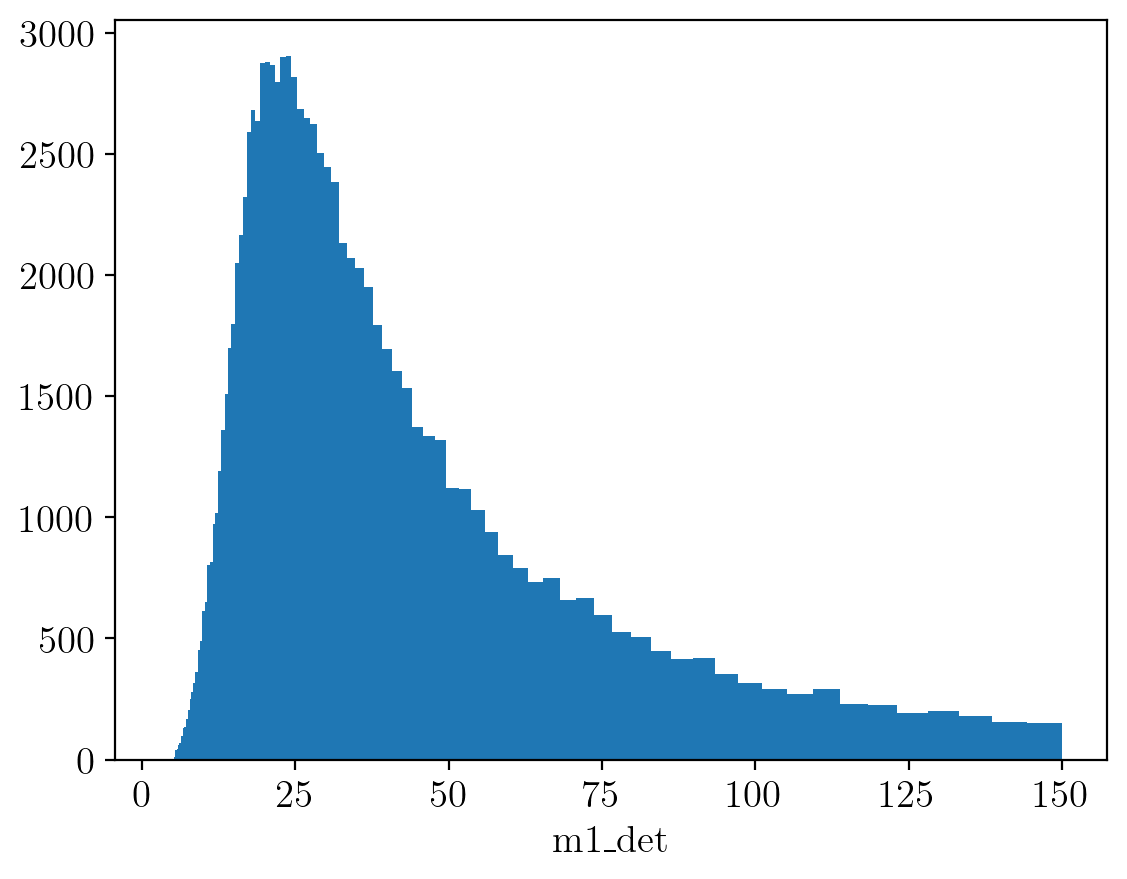

In [3]:
input_file = 'smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])

m1s = conv.mass1_from_mchirp_eta(Mcs, etas)
mtots = conv.mtotal_from_mchirp_eta(Mcs, etas)


plt.hist(m1s, bins = np.geomspace(3.0, 150.0, 100))
plt.xlabel('m1_det')
plt.show()


# Naive Implementation (same shift across detectors)

In [4]:
def set_up_waveforms(i, net_key = '3G', approx1 = 'IMRPhenomXAS', approx2 = 'IMRPhenomD', inj_params=None):
    if inj_params is None:
        inj_params = {
            'Mc':    Mcs[i],
            'eta':   etas[i],
            'chi1x': 0.,
            'chi2x': 0.,
            'chi1y': 0.,
            'chi2y': 0.,
            'chi1z': chi1z[i],
            'chi2z': chi2z[i],
            'DL':    DLs[i],
            'tc':    0,
            'phic':  0,
            'iota':  iotas[i],
            'ra':    ras[i],
            'dec':   decs[i],
            'psi':   psis[i],
            'gmst0': 0,
            'hybr': 0.0
        } 


    d_f = 2**-4
    f_low = 5.0
    mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
    f_high = np.round(4*br.f_isco_Msolar(mtotal))

    net_1 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=True)

    delta_f = net_1.f[1] - net_1.f[0]
    psd = FrequencySeries(net_1.detectors[0].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_1.f, net_1.detectors[0].f, assume_unique=True)

    hp1_pyc = FrequencySeries(net_1.hfp[freq_mask], delta_f=delta_f)
    hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) / psd).data)

    return net_1, [inj_params, f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm]


def overlap_func(params, args):
        
        inj_params,f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm  = args

        tc, phic = params

        if (phic>2*np.pi or phic<0.0):
            return +100000
        
        inj_params_opt = inj_params.copy()
        inj_params_opt['tc'] = tc
        inj_params_opt['phic'] = phic

        net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)
        hp2_pyc = FrequencySeries(net_2_try.hfp[freq_mask], delta_f=delta_f)
        hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

        inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm)) # match

        return 1-inner_prod # mismatch



def cv_biases_aligned_misaligned(args2):
    inj_params, tc_opt, phic_opt, approx1, approx2, net_key, f_high = args2

    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc_opt
    inj_params_opt['phic'] = phic_opt

    # compute CV biases with and without aligning the waveforms
    net_2 = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)

    net_2_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)

    return net_2, net_2_opt

In [5]:
# i = 54837 # 'Golden' Binary
i = 47519 # 'Pessimistic' Binary

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

net_1, args = set_up_waveforms(i, net_key=net_key, approx1=approx1, approx2=approx2)
inj_params, f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm = args


2023-12-11 08:50:21,684 - Network - INFO : Polarizations calculated.
2023-12-11 08:50:21,685 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-12-11 08:50:21,690 - Network - INFO : Polarizations calculated.
2023-12-11 08:50:22,596 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-11 08:50:22,674 - Network - INFO : PSDs loaded.
2023-12-11 08:50:22,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-11 08:50:22,692 - Network - INFO : Detector responses calculated.
2023-12-11 08:50:22,693 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-11 08:50:22,694 - Network - INFO :    CE-40_C
2023-12-11 08:50:23,619 - Network - INFO :    CE-20_S
2023-12-11 08:50:24,318 - Network - INFO :    ET_ET1
2023-12-11 08:50:24,994 - Network - INFO :    ET_ET2
2023-12-11 08:50:25,669 - Network - INFO :    ET_ET3
2023-12-11 08:50:26,339 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-11 0

In [6]:
initial=[0., 0.]
result = minimize(overlap_func, initial, args=args, method='nelder-mead')
tc_opt, phic_opt = result.x

2023-12-11 08:51:19,915 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,920 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,925 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,930 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,934 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,938 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,942 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,947 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,951 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,955 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,959 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,962 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,966 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,970 - Network - INFO : Polarizations calculated.
2023-12-11 08:51:19,973 - Network 

In [7]:
print(result)
print(1-result.fun)
print(tc_opt, phic_opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002519309599476882
             x: [-6.197e-03  3.098e-03]
           nit: 51
          nfev: 91
 final_simplex: (array([[-6.197e-03,  3.098e-03],
                       [-6.197e-03,  3.036e-03],
                       [-6.197e-03,  3.020e-03]]), array([ 2.519e-04,  2.519e-04,  2.519e-04]))
0.9997480690400523
-0.006196967482566835 0.0030984837412834174


In [124]:
args2 = [inj_params, tc_opt, phic_opt, approx1, approx2, net_key, f_high]
net_no_opt, net_opt = cv_biases_aligned_misaligned(args2)
cv_biases_no_opt = net_no_opt.cutler_vallisneri_bias.tolist()[0]
cv_biases_opt = net_opt.cutler_vallisneri_bias.tolist()[0]

2023-11-28 14:45:38,762 - Network - INFO : Polarizations calculated.
2023-11-28 14:45:38,763 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-28 14:45:38,771 - Network - INFO : Polarizations calculated.
2023-11-28 14:45:39,579 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-28 14:45:39,624 - Network - INFO : PSDs loaded.
2023-11-28 14:45:39,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-28 14:45:39,653 - Network - INFO : Detector responses calculated.
2023-11-28 14:45:39,653 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-28 14:45:39,654 - Network - INFO :    CE-40_C
2023-11-28 14:45:40,207 - Network - INFO :    CE-20_S
2023-11-28 14:45:40,762 - Network - INFO :    ET_ET1
2023-11-28 14:45:41,325 - Network - INFO :    ET_ET2
2023-11-28 14:45:41,878 - Network - INFO :    ET_ET3
2023-11-28 14:45:42,428 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-28 1

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


faithfulness before aligning: 0.7074812990832503
faithfulness after aligning: 0.9997480690400519


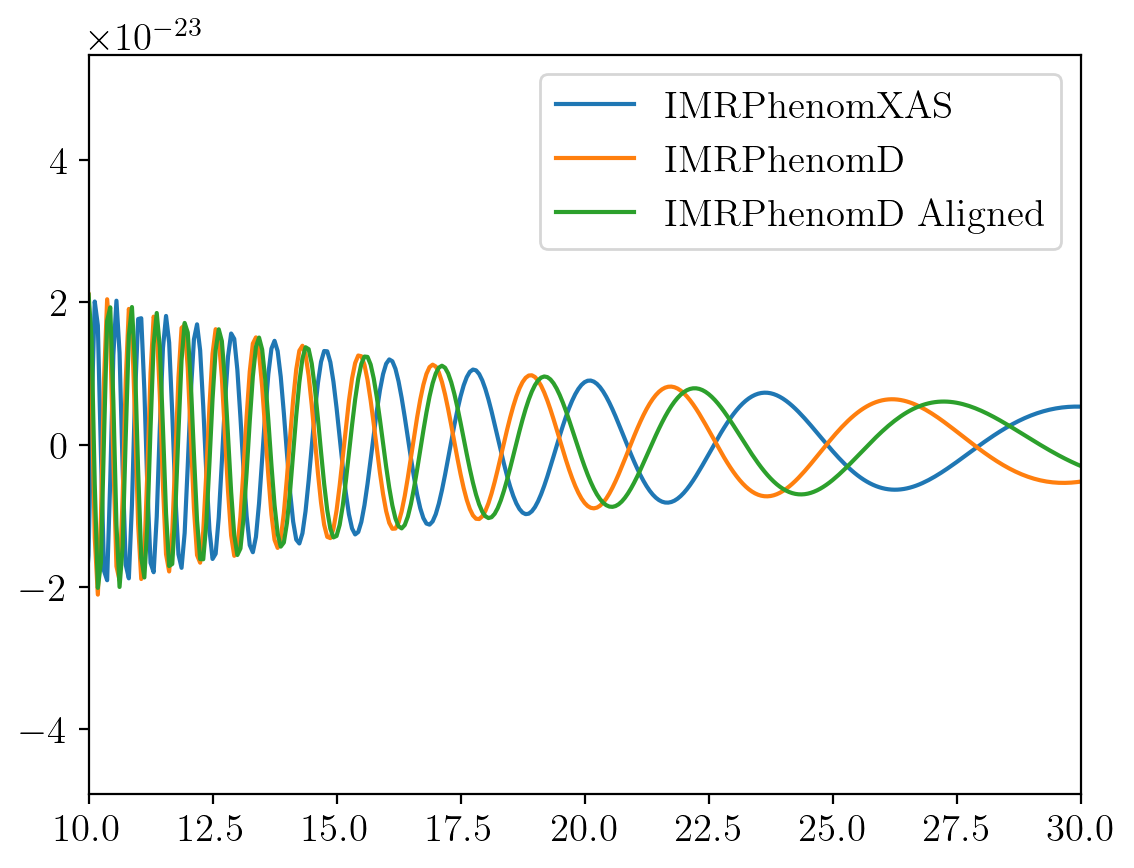

In [125]:
hp2_pyc = FrequencySeries(net_no_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
inner_prod_no_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

hp2_pyc = FrequencySeries(net_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
inner_prod_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

print("faithfulness before aligning:", inner_prod_no_opt)
print("faithfulness after aligning:", inner_prod_opt)

plt.plot(net_1.f, net_1.hfp, label='IMRPhenomXAS')
plt.plot(net_no_opt.f, net_no_opt.hfp, label='IMRPhenomD')
plt.plot(net_opt.f, net_opt.hfp, label='IMRPhenomD Aligned')

plt.xlim(10, 30)
plt.legend()
plt.show()


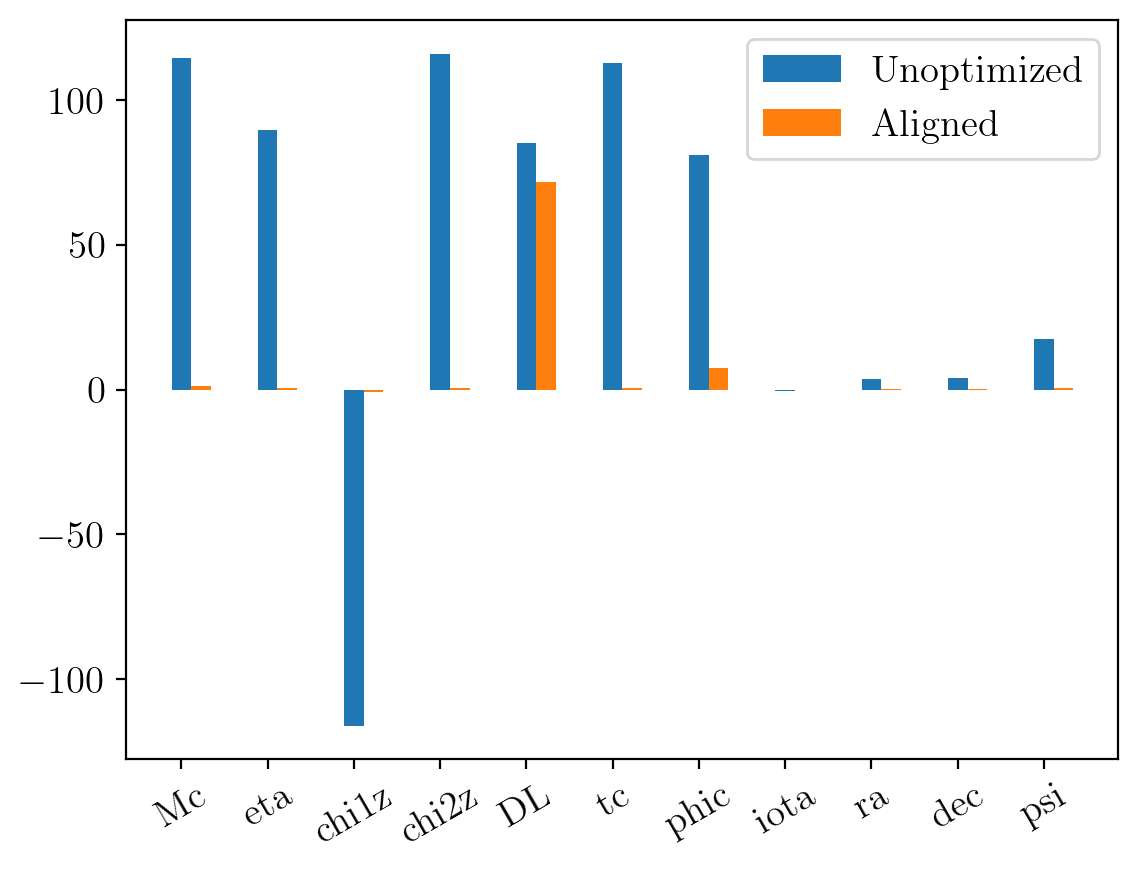

Mc, not: 114.578 sigma
Mc, opt: 1.217 sigma

eta, not: 89.612 sigma
eta, opt: 0.498 sigma

chi1z, not: -116.007 sigma
chi1z, opt: -0.824 sigma

chi2z, not: 116.087 sigma
chi2z, opt: 0.712 sigma

DL, not: 85.011 sigma
DL, opt: 71.742 sigma

tc, not: 112.907 sigma
tc, opt: 0.486 sigma

phic, not: 80.993 sigma
phic, opt: 7.324 sigma

iota, not: -0.408 sigma
iota, opt: -0.002 sigma

ra, not: 3.757 sigma
ra, opt: 0.110 sigma

dec, not: 4.009 sigma
dec, opt: 0.119 sigma

psi, not: 17.440 sigma
psi, opt: 0.457 sigma



In [82]:
err_no_opt = np.zeros(len(cv_biases_no_opt))
err_opt = np.zeros(len(cv_biases_opt))


for i, param in enumerate(net_opt.deriv_variables):
    err_no_opt[i] = net_no_opt.errs[param]
    err_opt[i] = net_opt.errs[param]


x = np.linspace(0, len(cv_biases_opt), len(cv_biases_opt))

width = 0.25
plt.bar(x, cv_biases_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, cv_biases_opt/err_opt, width=width, label='Aligned')

plt.xticks(x, net_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

for i, param in enumerate(net_opt.deriv_variables):
    bias1 = cv_biases_no_opt[i]/net_no_opt.errs[param]
    bias2 = cv_biases_opt[i]/net_opt.errs[param]
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

# Detector-specific time and phase shifts

The plan:
1. For a NETWORK of detectors: Evaluate the detector response waveforms for the signal ($h_{\rm TR}$) and the template ($h_{\rm AP}$) waveforms (no Fisher yet).

2. For each detector, find the optimal time and phase shifts ($\Delta t$, $\Delta \phi$) such that the overlap is maximized.

3. Compute the CV bias over the network with detector-specific shifts:

    3.1. Compute waveform responses and derivatives for $h_{\rm TR}$ for each DETECTOR separately, shifting the waveform by ($-\Delta t, -\Delta \phi$).
    
    3.2 Compute the NETWORK Fisher + Covariance matrix for the UNSHIFTED template waveform $h_{\rm AP}$.

    3.3 Compute the CV bias manually, using the network Covariance and detector-by-detector inner products.

    

## Step 1 (Detector-by-Detector Responses)

In [5]:
# i = 54837 # 'Golden' Binary
i = 47519 # 'Pessimistic' Binary

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 


d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_1 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=True, calc_derivs = False, calc_fisher=False)
net_2 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=True, calc_derivs = False, calc_fisher=False)


2023-12-12 14:22:57,825 - Network - INFO : Polarizations calculated.
2023-12-12 14:22:57,881 - Network - INFO : PSDs loaded.
2023-12-12 14:22:57,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-12 14:22:57,897 - Network - INFO : Detector responses calculated.
2023-12-12 14:22:57,901 - Network - INFO : SNRs calculated.
2023-12-12 14:22:57,904 - Network - INFO : Polarizations calculated.
2023-12-12 14:22:57,966 - Network - INFO : PSDs loaded.
2023-12-12 14:22:57,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-12 14:22:57,998 - Network - INFO : Detector responses calculated.
2023-12-12 14:22:58,002 - Network - INFO : SNRs calculated.


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(5.0, 10.0)

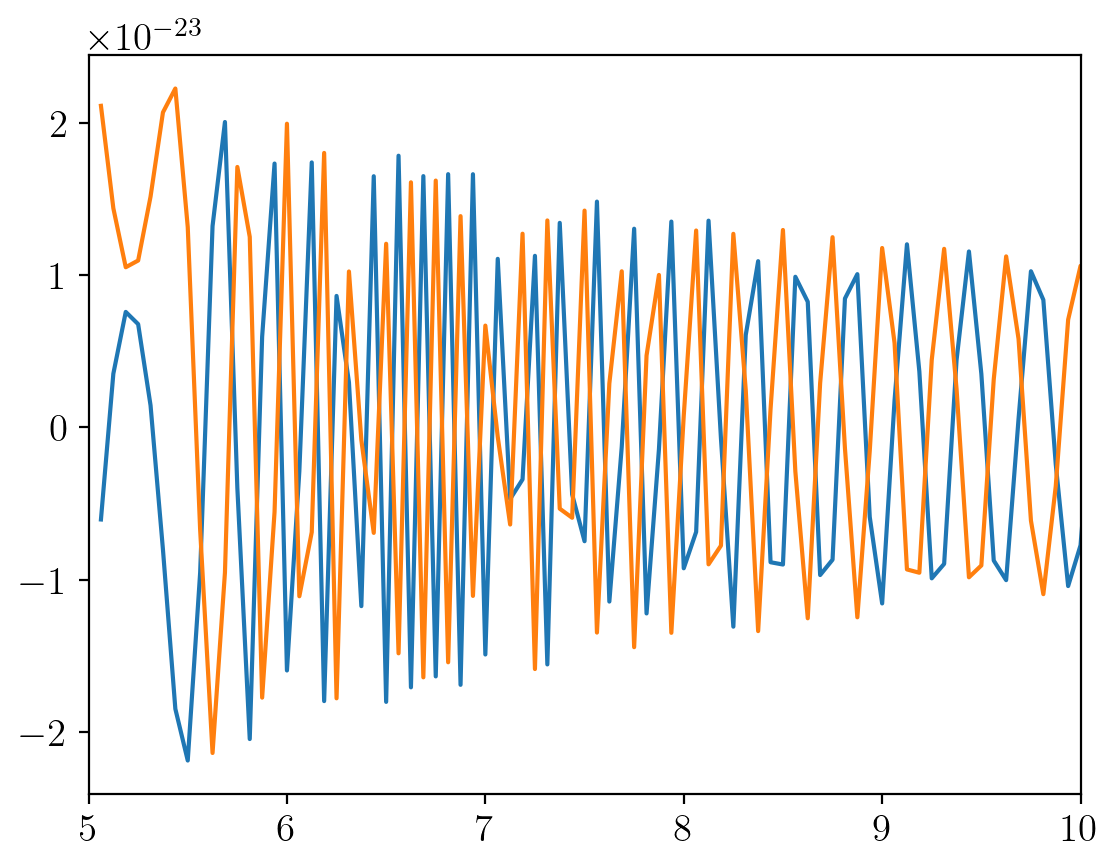

In [6]:
plt.plot(net_1.detectors[0].f, net_1.detectors[0].hf)
plt.plot(net_2.detectors[0].f, net_2.detectors[0].hf)

plt.xlim(5, 10)

In [7]:
def inner_prod(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    
    return  np.abs(4*np.real(integrate.simpson(y= h1*np.conjugate(h2) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm)))

In [15]:
d = 0
h1 = net_1.detectors[d].hf
h2 = net_2.detectors[d].hf
f = net_1.detectors[d].f
Sn = net_1.detectors[d].psd

overlap = inner_prod(h1, h2, Sn, f)

network_spec_d = [net_1.detectors[d].det_key]

# h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
# h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
# overlap = 4*np.real(integrate.simpson(y= h1*np.conjugate(h2) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))
# overlap
# plt.plot(f, h1)
# plt.plot(f, h2)
# plt.plot(f, Sn)
# plt.loglog()

['CE-40_C']

In [16]:
def maximize_overlap(params, args):

    tc, phic = params

    f_high, approx2, network_spec_d, h1, h1_norm, Sn, f= args

    if (phic>2*np.pi or phic<0.0):
        return np.inf
    
    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc
    inj_params_opt['phic'] = phic

    net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_spec=network_spec_d, calc_detector_responses=True, calc_derivs = False, calc_fisher=False)
    
    return 1- inner_prod(h1, h2, Sn, f)

# Maximize Unnormalized Overlap Function
(gives the SAME result as normalized)

In [87]:
def overlap_func_unnormalized(params, args):
        
        inj_params,f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm  = args

        tc, phic = params

        if (phic>2*np.pi or phic<0.0):
            return +100000
        
        inj_params_opt = inj_params.copy()
        inj_params_opt['tc'] = tc
        inj_params_opt['phic'] = phic

        net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)
        hp2_pyc = FrequencySeries(net_2_try.hfp[freq_mask], delta_f=delta_f)
        hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

        overlap = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) 

        return - np.abs(overlap)

In [88]:
# i = 54837 # 'Golden' Binary
i = 47519 # 'Pessimistic' Binary

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

net_1, args = set_up_waveforms(i, net_key=net_key, approx1=approx1, approx2=approx2)
inj_params, f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm = args


2023-11-28 14:16:23,617 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:23,618 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-28 14:16:23,622 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:24,558 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-28 14:16:24,642 - Network - INFO : PSDs loaded.
2023-11-28 14:16:24,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-28 14:16:24,662 - Network - INFO : Detector responses calculated.
2023-11-28 14:16:24,662 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-28 14:16:24,663 - Network - INFO :    CE-40_C
2023-11-28 14:16:25,360 - Network - INFO :    CE-20_S
2023-11-28 14:16:26,122 - Network - INFO :    ET_ET1
2023-11-28 14:16:26,810 - Network - INFO :    ET_ET2
2023-11-28 14:16:27,534 - Network - INFO :    ET_ET3
2023-11-28 14:16:28,186 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-28 1

In [89]:
initial=[0., 0.]
result = minimize(overlap_func_unnormalized, initial, args=args, method='nelder-mead')
tc_opt, phic_opt = result.x

2023-11-28 14:16:57,903 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,908 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,914 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,918 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,923 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,928 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,933 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,937 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,941 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,945 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,949 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,953 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,958 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,962 - Network - INFO : Polarizations calculated.
2023-11-28 14:16:57,966 - Network 

In [90]:
print(result)
print(1-result.fun)
print(tc_opt, phic_opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -528694.597428648
             x: [-6.197e-03  3.098e-03]
           nit: 51
          nfev: 91
 final_simplex: (array([[-6.197e-03,  3.098e-03],
                       [-6.197e-03,  3.036e-03],
                       [-6.197e-03,  3.020e-03]]), array([-5.287e+05, -5.287e+05, -5.287e+05]))
528695.597428648
-0.006196967482566835 0.0030984837412834174


In [91]:
args2 = [inj_params, tc_opt, phic_opt, approx1, approx2, net_key, f_high]
net_no_opt, net_opt = cv_biases_aligned_misaligned(args2)
cv_biases_no_opt = net_no_opt.cutler_vallisneri_bias.tolist()[0]
cv_biases_opt = net_opt.cutler_vallisneri_bias.tolist()[0]

2023-11-28 14:17:31,826 - Network - INFO : Polarizations calculated.
2023-11-28 14:17:31,827 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-28 14:17:31,834 - Network - INFO : Polarizations calculated.
2023-11-28 14:17:32,692 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-28 14:17:32,741 - Network - INFO : PSDs loaded.
2023-11-28 14:17:32,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-28 14:17:32,773 - Network - INFO : Detector responses calculated.
2023-11-28 14:17:32,774 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-28 14:17:32,774 - Network - INFO :    CE-40_C
2023-11-28 14:17:33,362 - Network - INFO :    CE-20_S
2023-11-28 14:17:33,925 - Network - INFO :    ET_ET1
2023-11-28 14:17:34,475 - Network - INFO :    ET_ET2
2023-11-28 14:17:35,040 - Network - INFO :    ET_ET3
2023-11-28 14:17:35,600 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-28 1

faithfulness before aligning: 0.7074812990832503
faithfulness after aligning: 0.9997480690400519


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


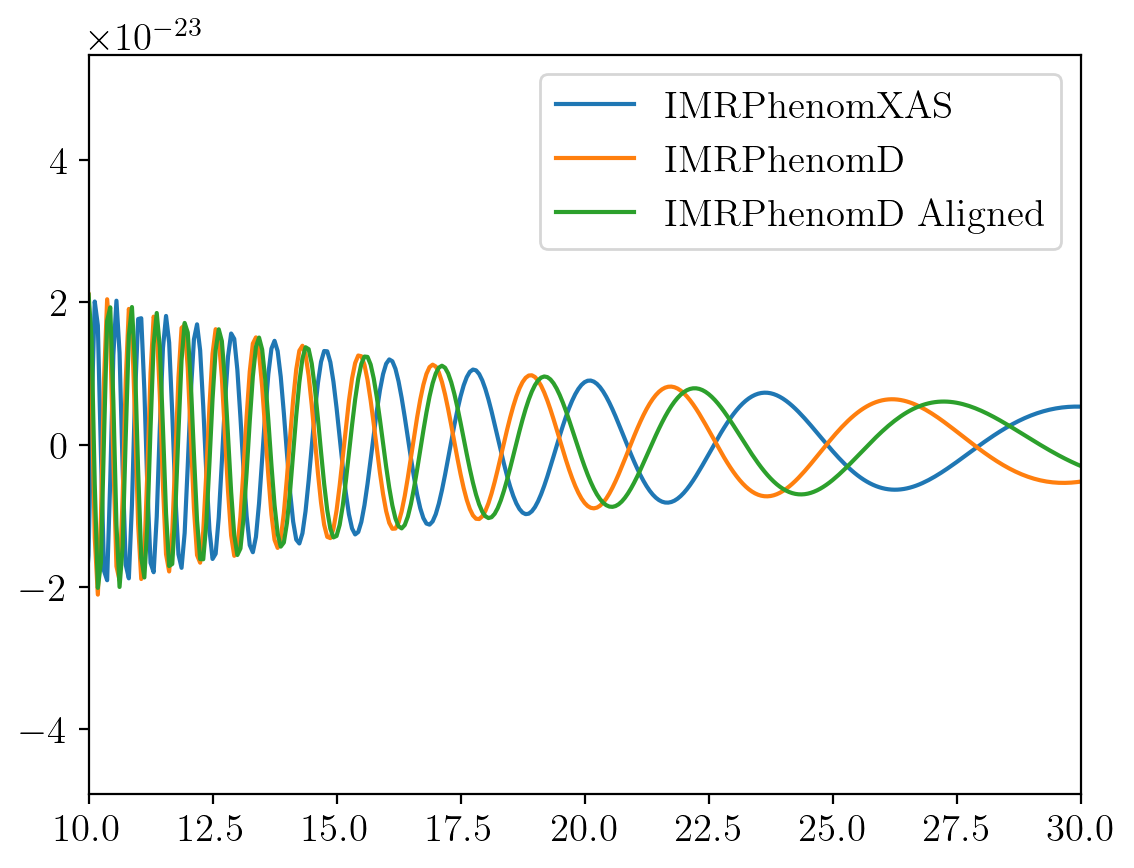

In [92]:
hp2_pyc = FrequencySeries(net_no_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
inner_prod_no_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

hp2_pyc = FrequencySeries(net_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
inner_prod_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

print("faithfulness before aligning:", inner_prod_no_opt)
print("faithfulness after aligning:", inner_prod_opt)

plt.plot(net_1.f, net_1.hfp, label='IMRPhenomXAS')
plt.plot(net_no_opt.f, net_no_opt.hfp, label='IMRPhenomD')
plt.plot(net_opt.f, net_opt.hfp, label='IMRPhenomD Aligned')

plt.xlim(10, 30)
plt.legend()
plt.show()


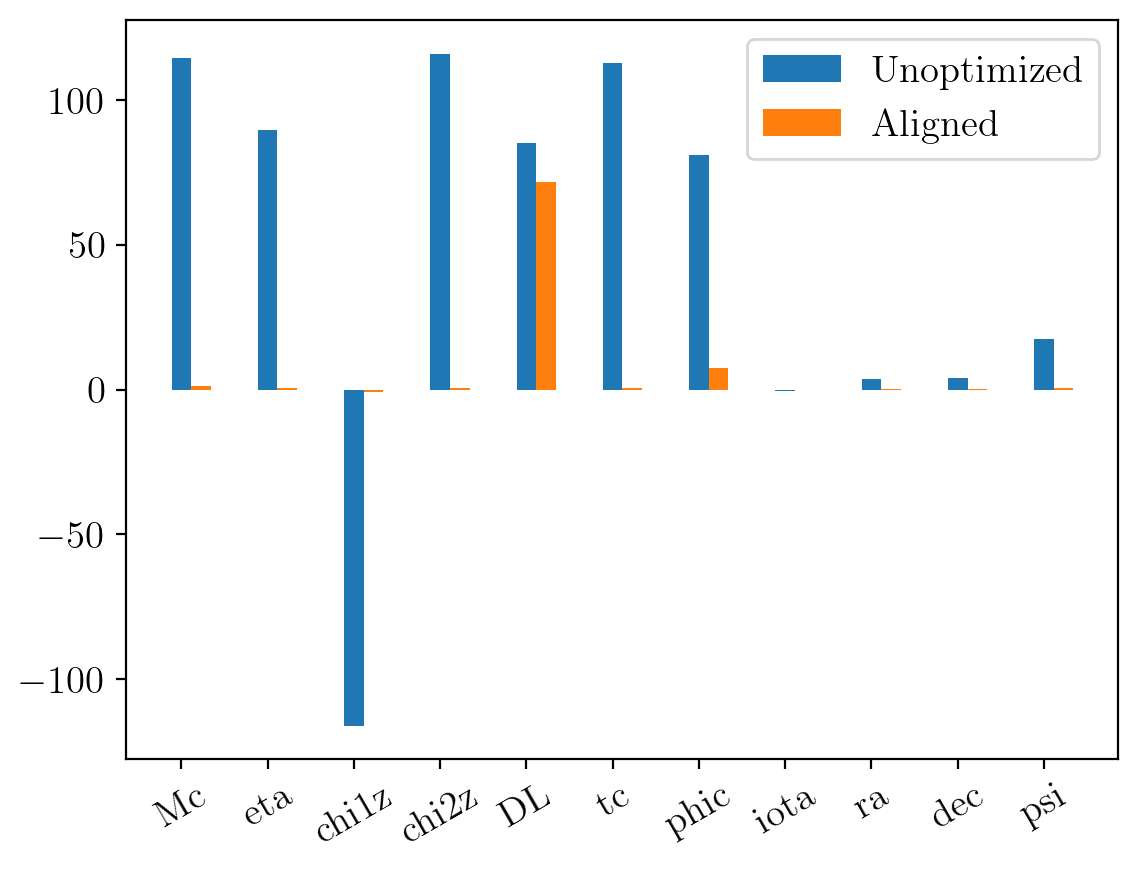

Mc, not: 114.578 sigma
Mc, opt: 1.217 sigma

eta, not: 89.612 sigma
eta, opt: 0.498 sigma

chi1z, not: -116.007 sigma
chi1z, opt: -0.824 sigma

chi2z, not: 116.087 sigma
chi2z, opt: 0.712 sigma

DL, not: 85.011 sigma
DL, opt: 71.742 sigma

tc, not: 112.907 sigma
tc, opt: 0.486 sigma

phic, not: 80.993 sigma
phic, opt: 7.324 sigma

iota, not: -0.408 sigma
iota, opt: -0.002 sigma

ra, not: 3.757 sigma
ra, opt: 0.110 sigma

dec, not: 4.009 sigma
dec, opt: 0.119 sigma

psi, not: 17.440 sigma
psi, opt: 0.457 sigma



In [93]:
err_no_opt = np.zeros(len(cv_biases_no_opt))
err_opt = np.zeros(len(cv_biases_opt))


for i, param in enumerate(net_opt.deriv_variables):
    err_no_opt[i] = net_no_opt.errs[param]
    err_opt[i] = net_opt.errs[param]


x = np.linspace(0, len(cv_biases_opt), len(cv_biases_opt))

width = 0.25
plt.bar(x, cv_biases_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, cv_biases_opt/err_opt, width=width, label='Aligned')

plt.xticks(x, net_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

for i, param in enumerate(net_opt.deriv_variables):
    bias1 = cv_biases_no_opt[i]/net_no_opt.errs[param]
    bias2 = cv_biases_opt[i]/net_opt.errs[param]
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()


# Pycbc Mismatch Comparison

In [150]:
# The pycbc optimization only happens over tc. So I need to define my routine the same way.
def overlap_func_tc(params, args):
        inj_params,f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm  = args
        
        tc = params/1000
        
        inj_params_opt = inj_params.copy()
        inj_params_opt['tc'] = tc

        net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)
        hp2_pyc = FrequencySeries(net_2_try.hfp[freq_mask], delta_f=delta_f)
        hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

        inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm)) # match

        return 1-inner_prod # mismatch

In [151]:
# i = 54837 # 'Golden' Binary
i = 47519 # 'Pessimistic' Binary

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

net_1, args = set_up_waveforms(i, net_key=net_key, approx1=approx1, approx2=approx2)
inj_params, f_high, approx2, net_key, freq_mask, delta_f, psd, hp1_pyc, hp1_norm = args


2023-11-27 12:16:52,026 - Network - INFO : Polarizations calculated.
2023-11-27 12:16:52,026 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-27 12:16:52,030 - Network - INFO : Polarizations calculated.
2023-11-27 12:16:52,921 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-27 12:16:52,990 - Network - INFO : PSDs loaded.
2023-11-27 12:16:52,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-27 12:16:53,009 - Network - INFO : Detector responses calculated.
2023-11-27 12:16:53,010 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-27 12:16:53,011 - Network - INFO :    CE-40_C
2023-11-27 12:16:53,702 - Network - INFO :    CE-20_S
2023-11-27 12:16:54,376 - Network - INFO :    ET_ET1
2023-11-27 12:16:55,043 - Network - INFO :    ET_ET2
2023-11-27 12:16:55,713 - Network - INFO :    ET_ET3
2023-11-27 12:16:56,388 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-27 1

In [161]:
initial=[0.]
result = minimize(overlap_func_tc, initial, args=args, method='nelder-mead')
tc_opt = result.x[0]/1000
phic_opt = inj_params['phic']

2023-11-27 12:19:17,956 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:17,962 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:17,970 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:17,976 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:17,982 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:17,987 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:17,993 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:17,999 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:18,012 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:18,018 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:18,029 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:18,037 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:18,042 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:18,048 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:18,065 - Network 

## Grid search for minima

In [131]:
N = 701
mismatches = np.zeros(N)
tc_guesses = np.linspace(-0.1, 0.1, N)
for i, tc_guess in enumerate(tc_guesses):
    mismatches[i] = overlap_func_tc(tc_guess, args)

2023-11-27 12:11:51,373 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,378 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,383 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,387 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,391 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,395 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,400 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,404 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,409 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,413 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,418 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,423 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,427 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,431 - Network - INFO : Polarizations calculated.
2023-11-27 12:11:51,435 - Network 

-0.006285714285714283
-0.006187500000000002


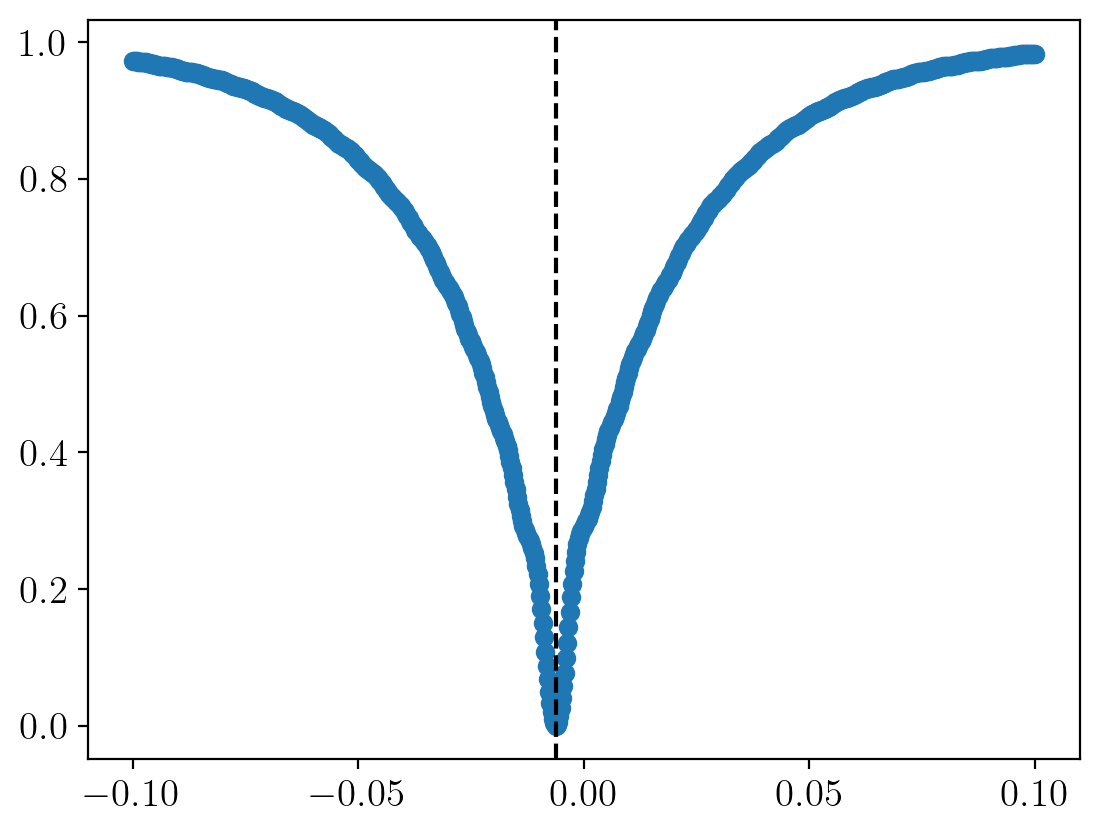

In [132]:
plt.scatter(tc_guesses, mismatches)
plt.axvline(x=tc_opt, ls='--', color='k')
print(tc_guesses[np.argmin(mismatches)])
print(tc_opt)

##

In [162]:
print(result)
print(1-result.fun)
# print(result.fun)
print(tc_opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.00025193098092068933
             x: [-6.197e+00]
           nit: 30
          nfev: 60
 final_simplex: (array([[-6.197e+00],
                       [-6.197e+00]]), array([ 2.519e-04,  2.519e-04]))
0.9997480690190793
-0.006196937500000008


In [163]:
args2 = [inj_params, tc_opt, phic_opt, approx1, approx2, net_key, f_high]

net_no_opt, net_opt = cv_biases_aligned_misaligned(args2)
cv_biases_no_opt = net_no_opt.cutler_vallisneri_bias.tolist()[0]
cv_biases_opt = net_opt.cutler_vallisneri_bias.tolist()[0]

2023-11-27 12:19:21,053 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:21,054 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-27 12:19:21,063 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:21,873 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-27 12:19:21,918 - Network - INFO : PSDs loaded.
2023-11-27 12:19:21,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-27 12:19:21,948 - Network - INFO : Detector responses calculated.
2023-11-27 12:19:21,948 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-27 12:19:21,949 - Network - INFO :    CE-40_C
2023-11-27 12:19:22,524 - Network - INFO :    CE-20_S
2023-11-27 12:19:23,091 - Network - INFO :    ET_ET1
2023-11-27 12:19:23,755 - Network - INFO :    ET_ET2
2023-11-27 12:19:24,713 - Network - INFO :    ET_ET3
2023-11-27 12:19:25,591 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-27 1

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Pycbc overlap: -0.6988639928580753
faithfulness before aligning: 0.7074812990832503

Pycbc optimized_match: 0.999737655952497
faithfulness after aligning: 0.9997480690190789



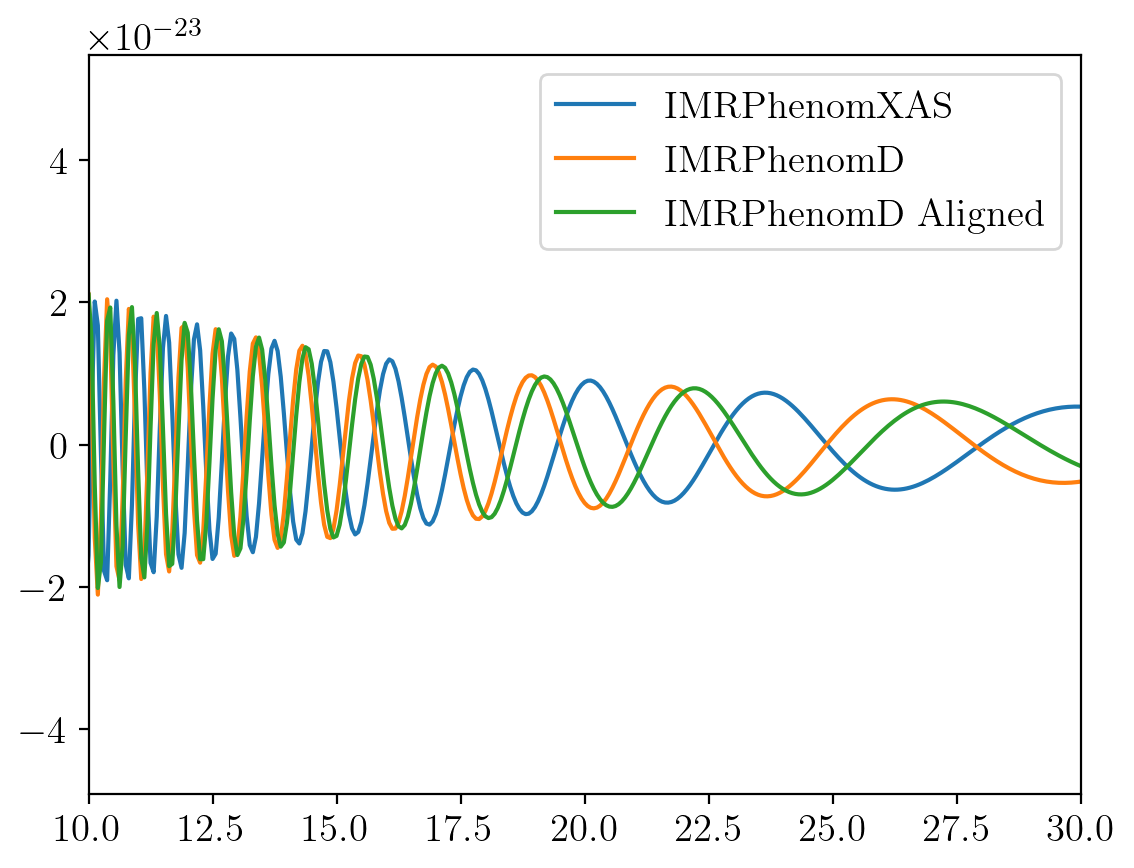

In [164]:
hp2_pyc = FrequencySeries(net_no_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

pycbc_no_opt = fil.overlap(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net_1.f[0], high_frequency_cutoff=net_1.f[-1])
pycbc_opt, index = fil.optimized_match(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net_1.f[0], high_frequency_cutoff=net_1.f[-1])

inner_prod_no_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

hp2_pyc_opt = FrequencySeries(net_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm_opt = np.sum((hp2_pyc_opt * np.conjugate(hp2_pyc_opt) / psd).data)
inner_prod_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc_opt)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm_opt))

print("Pycbc overlap:", pycbc_no_opt)
print("faithfulness before aligning:", inner_prod_no_opt)
print()
print("Pycbc optimized_match:", pycbc_opt)
print("faithfulness after aligning:", inner_prod_opt)

print()
plt.plot(net_1.f, net_1.hfp, label='IMRPhenomXAS')
plt.plot(net_no_opt.f, net_no_opt.hfp, label='IMRPhenomD')
plt.plot(net_opt.f, net_opt.hfp, label='IMRPhenomD Aligned')

plt.xlim(10, 30)
plt.legend()
plt.show()


In [165]:
hp2_pyc = FrequencySeries(net_no_opt.hfp[freq_mask], delta_f=delta_f)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

pycbc_opt, index = fil.optimized_match(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net_1.f[0], high_frequency_cutoff=net_1.f[-1])

tc_opt_pycbc = int(index)*hp1_pyc.delta_t

args2 = [inj_params, tc_opt_pycbc, phic_opt, approx1, approx2, net_key, f_high]
net_no_opt, net_opt_pycbc = cv_biases_aligned_misaligned(args2)
cv_biases_no_opt = net_no_opt.cutler_vallisneri_bias.tolist()[0]
cv_biases_opt_pycbc = net_opt_pycbc.cutler_vallisneri_bias.tolist()[0]

2023-11-27 12:19:32,401 - Network - INFO : Polarizations calculated.
2023-11-27 12:19:32,402 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-27 12:19:32,412 - Network - INFO : Polarizations calculated.


2023-11-27 12:19:33,783 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-27 12:19:33,854 - Network - INFO : PSDs loaded.
2023-11-27 12:19:33,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-27 12:19:33,887 - Network - INFO : Detector responses calculated.
2023-11-27 12:19:33,888 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-27 12:19:33,888 - Network - INFO :    CE-40_C
2023-11-27 12:19:34,717 - Network - INFO :    CE-20_S
2023-11-27 12:19:35,537 - Network - INFO :    ET_ET1
2023-11-27 12:19:36,350 - Network - INFO :    ET_ET2
2023-11-27 12:19:37,155 - Network - INFO :    ET_ET3
2023-11-27 12:19:37,969 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-27 12:19:37,972 - Network - INFO : SNRs calculated.
2023-11-27 12:19:37,973 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-27 12:19:37,974 - Network - INFO :    CE-40_C
2023-11-27 12:19:38,030 - Network - INFO :

In [166]:
print(tc_opt)
print(tc_opt_pycbc)

-0.006196937500000008
15.99166087560806


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


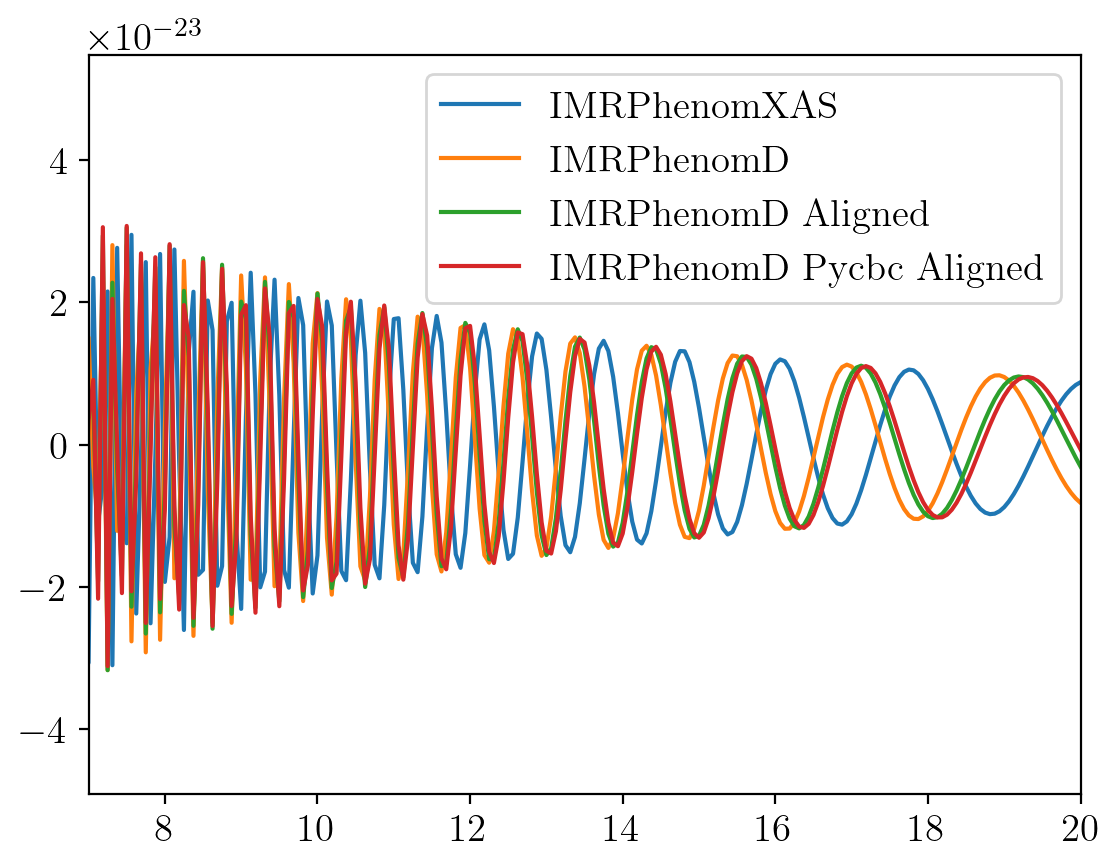

In [167]:
plt.plot(net_1.f, net_1.hfp, label='IMRPhenomXAS')
plt.plot(net_no_opt.f, net_no_opt.hfp, label='IMRPhenomD')
plt.plot(net_opt.f, net_opt.hfp, label='IMRPhenomD Aligned')
plt.plot(net_opt_pycbc.f, net_opt_pycbc.hfp, label='IMRPhenomD Pycbc Aligned')


plt.xlim(7, 20)
plt.legend()
plt.show()

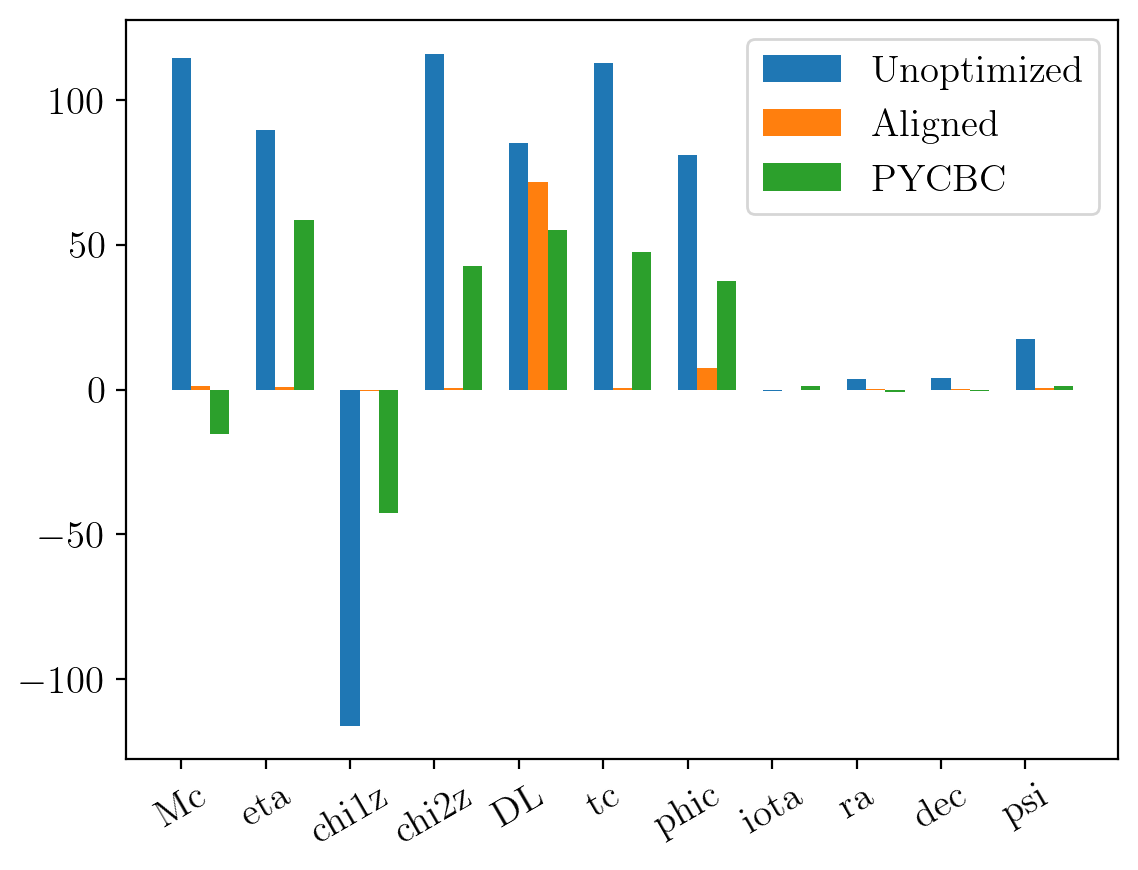

Mc, not: 114.578 sigma
Mc, opt: 1.091 sigma
Mc, opt pycbc: -15.447 sigma

eta, not: 89.612 sigma
eta, opt: 0.920 sigma
eta, opt pycbc: 58.641 sigma

chi1z, not: -116.007 sigma
chi1z, opt: -0.551 sigma
chi1z, opt pycbc: -42.578 sigma

chi2z, not: 116.087 sigma
chi2z, opt: 0.704 sigma
chi2z, opt pycbc: 42.617 sigma

DL, not: 85.011 sigma
DL, opt: 71.787 sigma
DL, opt pycbc: 55.211 sigma

tc, not: 112.907 sigma
tc, opt: 0.710 sigma
tc, opt pycbc: 47.463 sigma

phic, not: 80.993 sigma
phic, opt: 7.509 sigma
phic, opt pycbc: 37.355 sigma

iota, not: -0.408 sigma
iota, opt: -0.010 sigma
iota, opt pycbc: 1.242 sigma

ra, not: 3.757 sigma
ra, opt: 0.125 sigma
ra, opt pycbc: -0.670 sigma

dec, not: 4.009 sigma
dec, opt: 0.142 sigma
dec, opt pycbc: -0.512 sigma

psi, not: 17.440 sigma
psi, opt: 0.411 sigma
psi, opt pycbc: 1.242 sigma



In [168]:
err_no_opt = np.zeros(len(cv_biases_no_opt))
err_opt = np.zeros(len(cv_biases_opt))
err_opt_pycbc = np.zeros(len(cv_biases_opt_pycbc))


for i, param in enumerate(net_opt.deriv_variables):
    err_no_opt[i] = net_no_opt.errs[param]
    err_opt[i] = net_opt.errs[param]
    err_opt_pycbc[i] = net_opt_pycbc.errs[param]


x = np.linspace(0, len(cv_biases_opt), len(cv_biases_opt))

width = 0.25
plt.bar(x, cv_biases_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, cv_biases_opt/err_opt, width=width, label='Aligned')
plt.bar(x+2*width, cv_biases_opt_pycbc/err_opt_pycbc, width=width, label='PYCBC')

plt.xticks(x, net_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

for i, param in enumerate(net_opt.deriv_variables):
    bias1 = cv_biases_no_opt[i]/net_no_opt.errs[param]
    bias2 = cv_biases_opt[i]/net_opt.errs[param]
    bias3 = cv_biases_opt_pycbc[i]/net_opt_pycbc.errs[param]
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print(f"{param}, opt pycbc: {bias3:.3f} sigma")
    print()

# Pycbc Time domain waveforms

In [32]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

In [50]:
i = 54837
inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0,
        'hybr': 0.0
    } 

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

m1 = conv.mass1_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
m2 = conv.mass2_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
d_f = 2**-4
f_low = 5.0


In [51]:
hp1, hc1 = get_td_waveform(approximant=approx1,
                            mass1=m1,
                            mass2=m2,
                            spin1z=inj_params['chi1z'],
                            spin2z=inj_params['chi2z'],
                            distance=inj_params['DL'],
                            inclination=inj_params['iota'],
                            coa_time=0.0,
                            delta_t=1.0/4096,
                            f_lower=f_low)

declination = inj_params['dec']
right_ascension = inj_params['ra']
polarization = inj_params['psi']

det_3g = Detector('C1')
signal_3g_1 = det_3g.project_wave(hp1, hc1,  right_ascension, declination, polarization)

In [52]:
hp2, hc2 = get_td_waveform(approximant=approx2,
                            mass1=m1,
                            mass2=m2,
                            spin1z=inj_params['chi1z'],
                            spin2z=inj_params['chi2z'],
                            distance=inj_params['DL'],
                            inclination=inj_params['iota'],
                            coa_time=0.0,
                            delta_t=1.0/4096,
                            f_lower=f_low)

declination = inj_params['dec']
right_ascension = inj_params['ra']
polarization = inj_params['psi']

det_3g = Detector('C1')
signal_3g_2 = det_3g.project_wave(hp2, hc2,  right_ascension, declination, polarization)

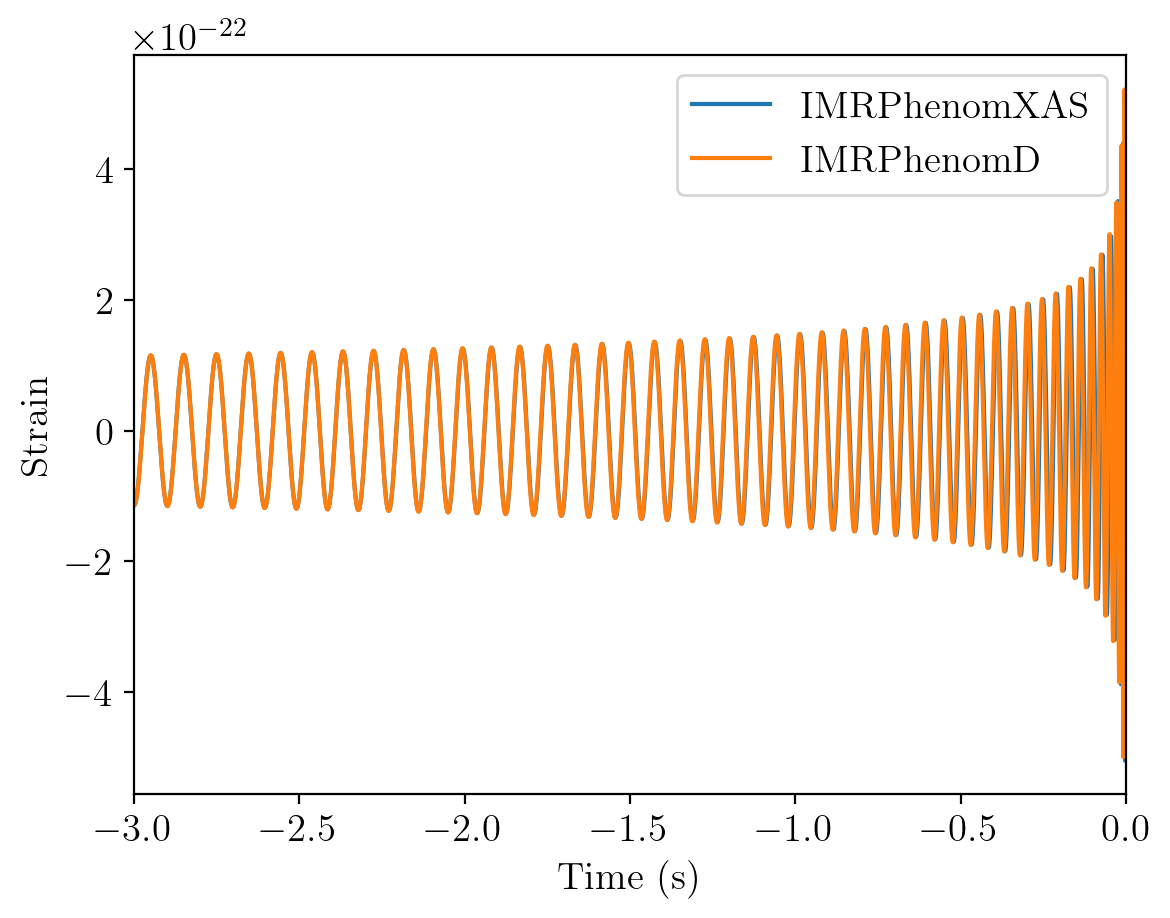

In [53]:
pp.plot(hp1.sample_times, hp1, label=approx1)
pp.plot(hp2.sample_times, hp2, label=approx2)

# pp.plot(signal_3g_1.sample_times, signal_3g_1, label='3G')

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.xlim(-3, 0)
pp.show()

In [67]:
# Compute optimized match and time shift
tlen = max(len(hp1), len(hp2))
hp1.resize(tlen)
hp2.resize(tlen)

pycbc_opt, index = fil.optimized_match(hp1, hp2, low_frequency_cutoff=f_low)
tc_opt_pycbc = int(index)*hp1.delta_t
print(pycbc_opt)
print(tc_opt_pycbc)

print(1-fil.overlap(hp1, hp2, low_frequency_cutoff=f_low))

0.9999157003329464
35.142578125
0.9999862604548999


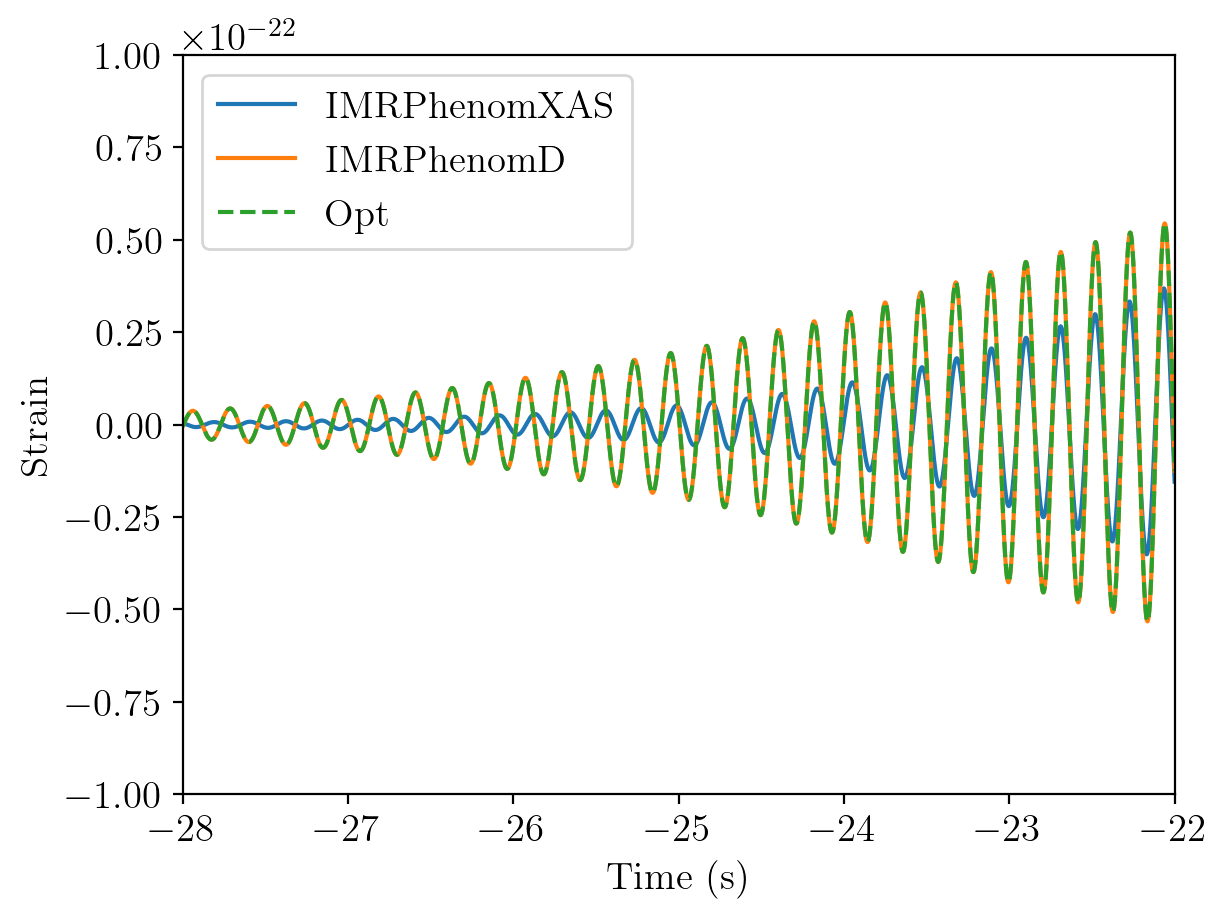

In [65]:
hp3, hc3 = get_td_waveform(approximant=approx2,
                            mass1=m1,
                            mass2=m2,
                            spin1z=inj_params['chi1z'],
                            spin2z=inj_params['chi2z'],
                            distance=inj_params['DL'],
                            inclination=inj_params['iota'],
                            coa_time=tc_opt_pycbc,
                            delta_t=1.0/4096,
                            f_lower=f_low)

declination = inj_params['dec']
right_ascension = inj_params['ra']
polarization = inj_params['psi']

det_3g = Detector('C1')
signal_3g_3 = det_3g.project_wave(hp2, hc2,  right_ascension, declination, polarization)
pp.plot(hp1.sample_times, hp1, label=approx1)
pp.plot(hp2.sample_times, hp2, label=approx2)
pp.plot(hp3.sample_times, hp3, label='Opt', ls='--')

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.xlim(-28, -22)
pp.ylim(-1e-22, 1e-22)
pp.show()

# Why are DL biases so bad?

$$ \Delta \theta^i =  (\Gamma_{\rm AP}^{-1})^{ij} \, \, (\partial_j (h_{\rm AP})| (h_{\rm TR}) - (h_{\rm AP})).$$

Naively, $h(\rm{DL}, \theta) = \frac{h(\theta)}{\rm{DL}}$, which means

$$ \frac{\partial h}{\partial \rm{DL}} = -\frac{h(\theta)}{\rm{DL}^2}$$

If $\rm{DL} >> 1$, then $\frac{\partial h}{\partial \rm{DL}}<<1$, and the covariance term $(\Gamma_{\rm AP}^{-1})^{\rm{DL, DL}} >> 1$. This is probably why the inferred biases are so large.

In [5]:
from tqdm import tqdm

## Bias changes with small tc variations

In [6]:
i = 47519 # 'Pessimistic' Binary

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 


d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

In [193]:
# CV biases as a function of tc
N = 101
tc_range = np.geomspace(1e-5, 1e-1, N)
cv_biases = np.zeros((N, 11))

for i in tqdm(range(N)):
    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = -tc_range[i]

    # compute CV biases after aligning the waveforms
    net_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_spec = ['CE-40_C'], f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)
    cv_biases[i] = net_opt.cutler_vallisneri_bias.tolist()[0]


  0%|          | 0/101 [00:00<?, ?it/s]2023-11-27 12:39:32,480 - Network - INFO : Polarizations calculated.
2023-11-27 12:39:32,481 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-27 12:39:32,488 - Network - INFO : Polarizations calculated.
2023-11-27 12:39:33,315 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-27 12:39:33,324 - Network - INFO : PSDs loaded.
2023-11-27 12:39:33,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-27 12:39:33,332 - Network - INFO : Detector responses calculated.
2023-11-27 12:39:33,332 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-27 12:39:33,333 - Network - INFO :    CE-40_C
2023-11-27 12:39:33,896 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-27 12:39:33,898 - Network - INFO : SNRs calculated.
2023-11-27 12:39:33,899 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-27 12:39:33,899 - Network - INFO 

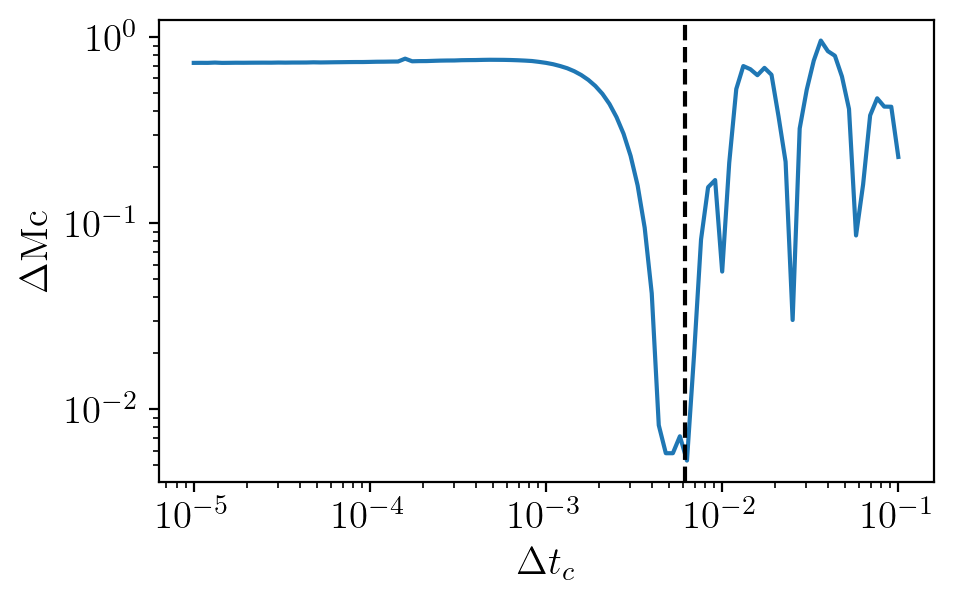

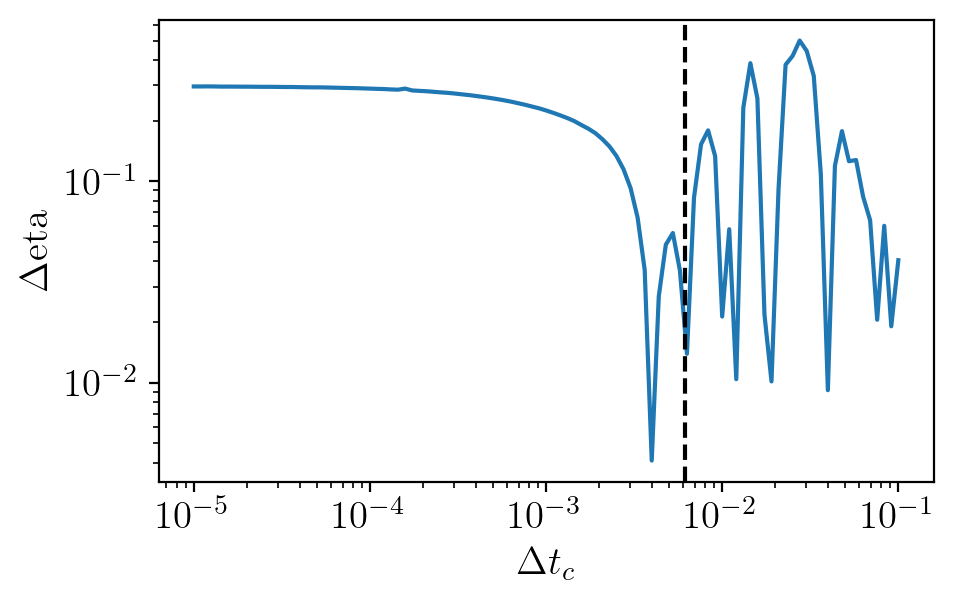

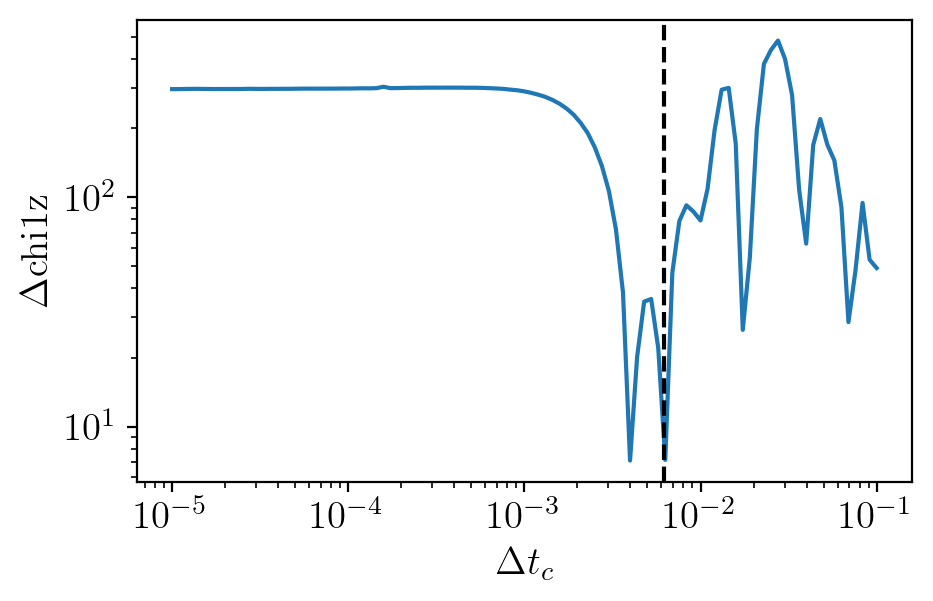

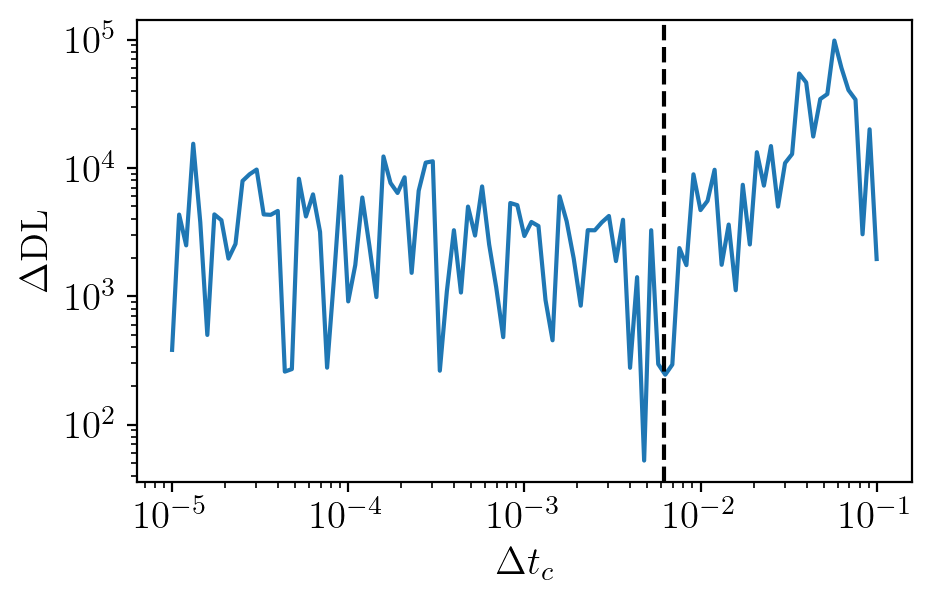

In [195]:
for var in ['Mc', 'eta', 'chi1z', 'DL']:
# for var in ['Mc', 'DL']:
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
    var_index = net_opt.deriv_variables.index(var)
    plt.plot(tc_range, np.abs(cv_biases[:,var_index]))
    plt.axvline(x=0.006187500000000002, ls='--', color='k')
    plt.loglog()
    plt.xlabel('$\Delta t_c$')
    plt.ylabel('$\Delta$' + var)
    plt.show()

If CV biases are only valid in the region that the biases increase linearly with small changes in the waveform, then most intrinsic parameters seem to satisfy the LSA while extrisic parameters don't.

## What about small changes in the SAME waveform model?
Is DL linear then?

### Dependence on tc

In [199]:
# i = 54837 # 'Golden' Binary
i = 47519 # 'Pessimistic' Binary


approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomXAS'

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 


d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_1 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_spec = ['CE-40_C'], calc_detector_responses=True)

delta_f = net_1.f[1] - net_1.f[0]
psd = FrequencySeries(net_1.detectors[0].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

# make sure that the detector and waveform frequency ranges overlap
freq_mask = np.in1d(net_1.f, net_1.detectors[0].f, assume_unique=True)

hp1_pyc = FrequencySeries(net_1.hfp[freq_mask], delta_f=delta_f)
hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) / psd).data)


# CV biases as a function of tc
N = 101
tc_range = np.geomspace(1e-5, 1e-1, N)
cv_biases = np.zeros((N, 11))

for i in tqdm(range(N)):
    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = -tc_range[i]

    # compute CV biases after aligning the waveforms
    net_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_spec = ['CE-40_C'], f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)
    cv_biases[i] = net_opt.cutler_vallisneri_bias.tolist()[0]


  0%|          | 0/101 [00:00<?, ?it/s]2023-11-27 12:53:14,731 - Network - INFO : Polarizations calculated.
2023-11-27 12:53:14,732 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-27 12:53:14,740 - Network - INFO : Polarizations calculated.
2023-11-27 12:53:15,595 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-27 12:53:15,605 - Network - INFO : PSDs loaded.
2023-11-27 12:53:15,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-27 12:53:15,620 - Network - INFO : Detector responses calculated.
2023-11-27 12:53:15,620 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-27 12:53:15,621 - Network - INFO :    CE-40_C
2023-11-27 12:53:16,214 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-27 12:53:16,216 - Network - INFO : SNRs calculated.
2023-11-27 12:53:16,216 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-27 12:53:16,217 - Network - INFO 

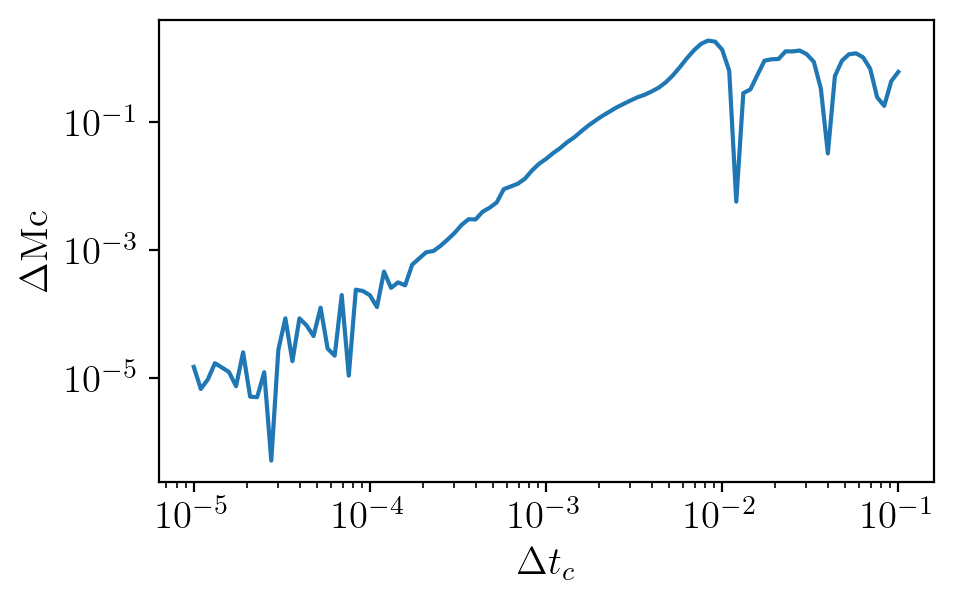

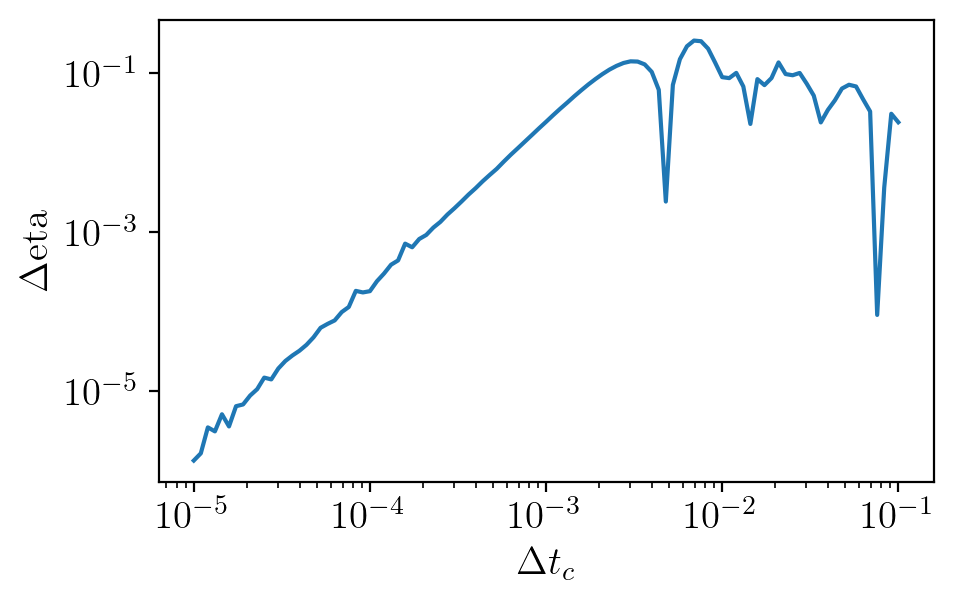

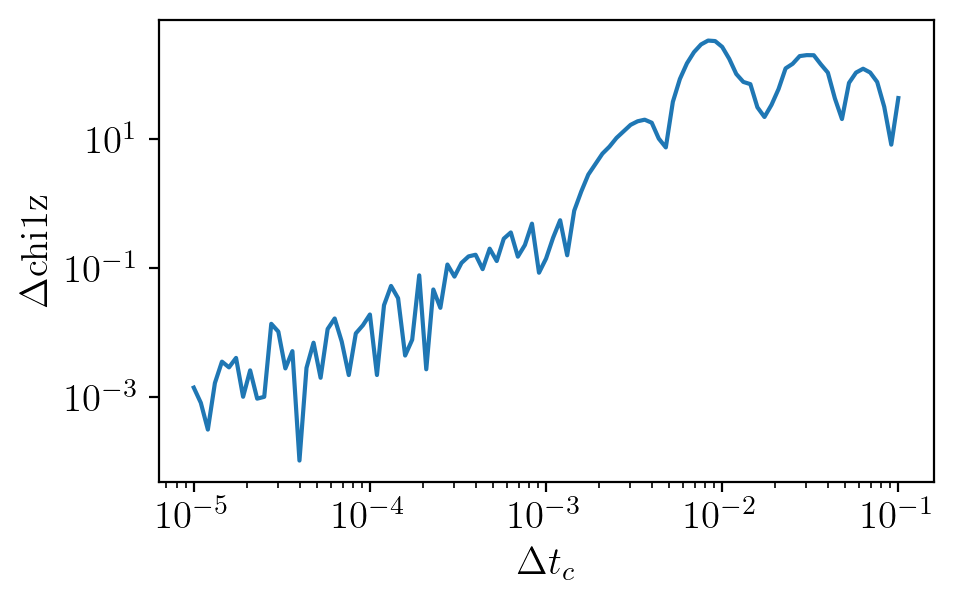

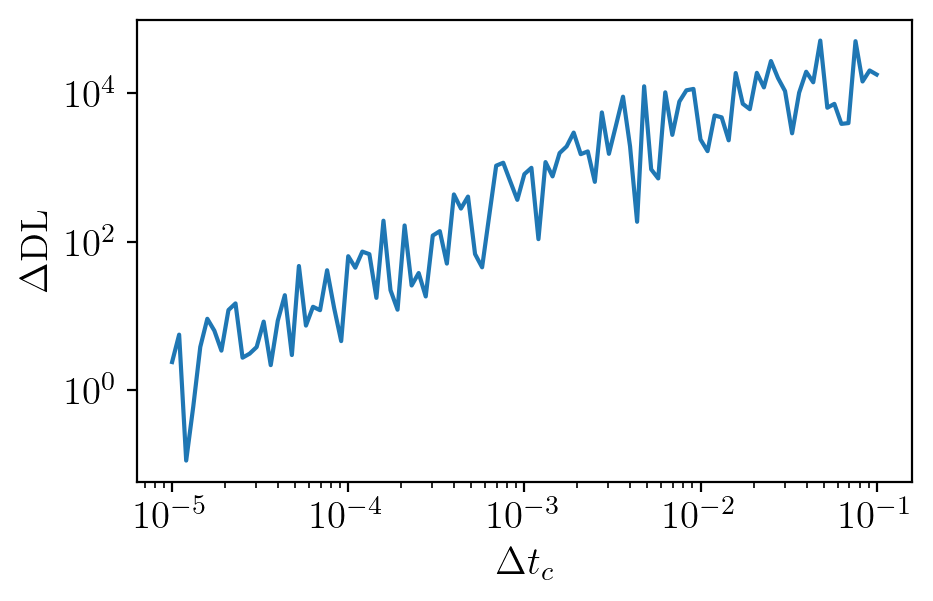

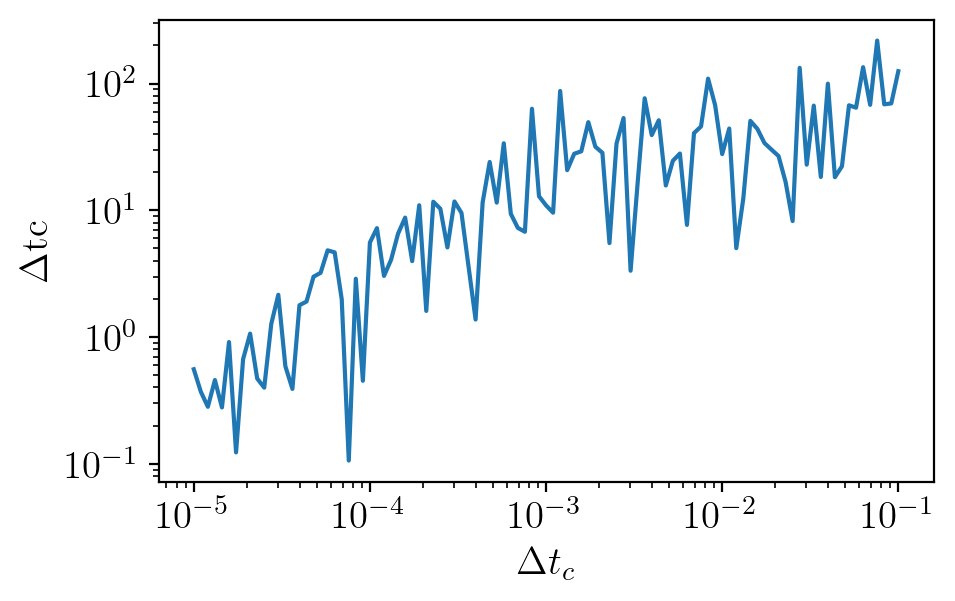

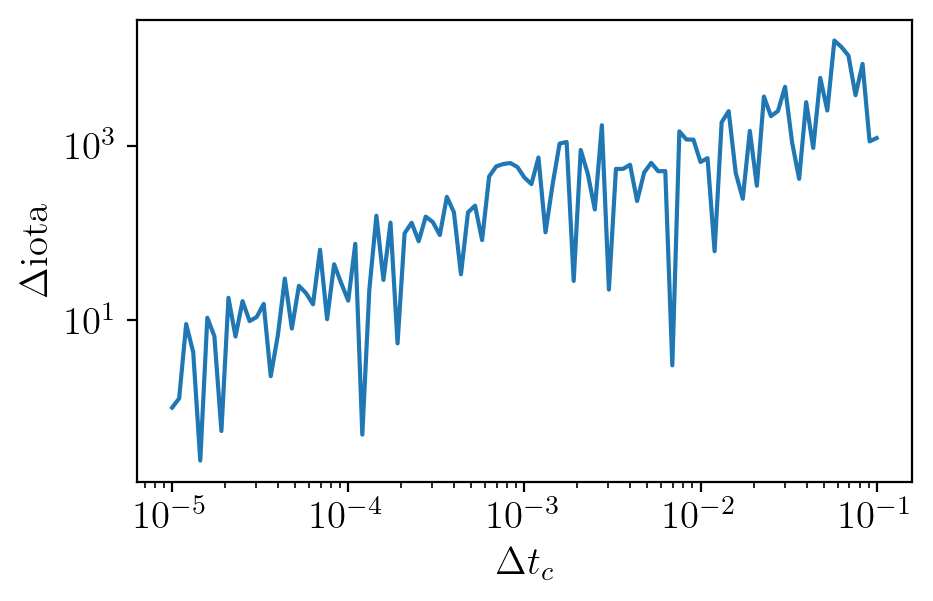

In [202]:
for var in ['Mc', 'eta', 'chi1z', 'DL', 'tc', 'iota']:
# for var in ['Mc', 'DL']:
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
    var_index = net_opt.deriv_variables.index(var)
    plt.plot(tc_range, np.abs(cv_biases[:,var_index]))
    plt.plot(tc_range, tc_range, ls='--', color='k')
    plt.loglog()
    plt.xlabel('$\Delta t_c$')
    plt.ylabel('$\Delta$' + var)
    plt.show()

### Bias Dependence on DL

In [211]:
# i = 54837 # 'Golden' Binary
i = 47519 # 'Pessimistic' Binary


net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomXAS'

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 


d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))


# CV biases as a function of DL
N = 101
DL_range = np.geomspace(1e-5, 1e4, N)
cv_biases = np.zeros((N, 11))

for i in tqdm(range(N)):
    inj_params_opt = inj_params.copy()
    inj_params_opt['DL'] += DL_range[i]

    # compute CV biases after aligning the waveforms
    net_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_spec = ['CE-40_C'], f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)
    cv_biases[i] = net_opt.cutler_vallisneri_bias.tolist()[0]


  0%|          | 0/101 [00:00<?, ?it/s]2023-11-27 13:24:39,163 - Network - INFO : Polarizations calculated.
2023-11-27 13:24:39,164 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-27 13:24:39,172 - Network - INFO : Polarizations calculated.
2023-11-27 13:24:40,016 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-27 13:24:40,024 - Network - INFO : PSDs loaded.
2023-11-27 13:24:40,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-27 13:24:40,032 - Network - INFO : Detector responses calculated.
2023-11-27 13:24:40,033 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-27 13:24:40,033 - Network - INFO :    CE-40_C
2023-11-27 13:24:40,619 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-27 13:24:40,621 - Network - INFO : SNRs calculated.
2023-11-27 13:24:40,621 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-27 13:24:40,622 - Network - INFO 

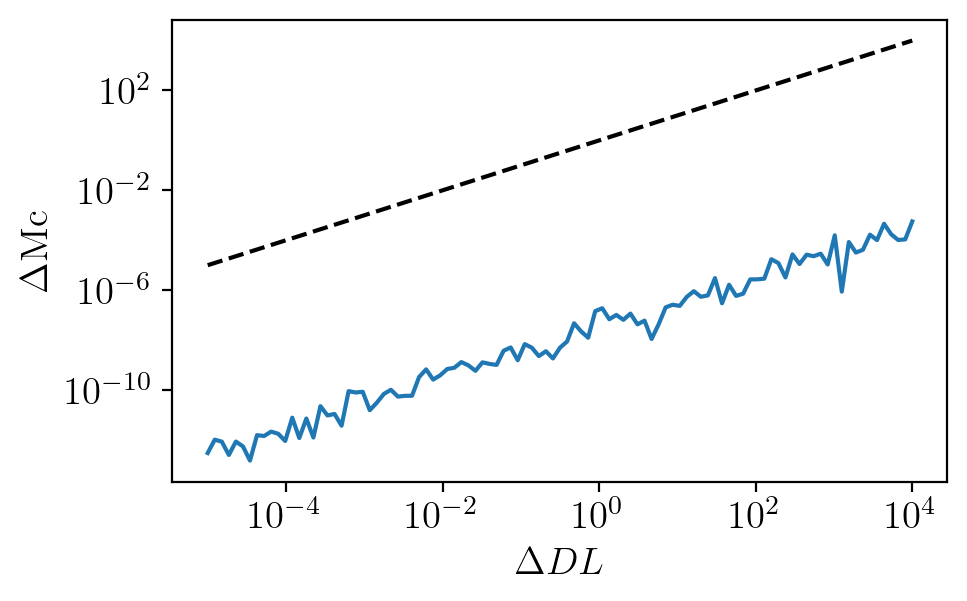

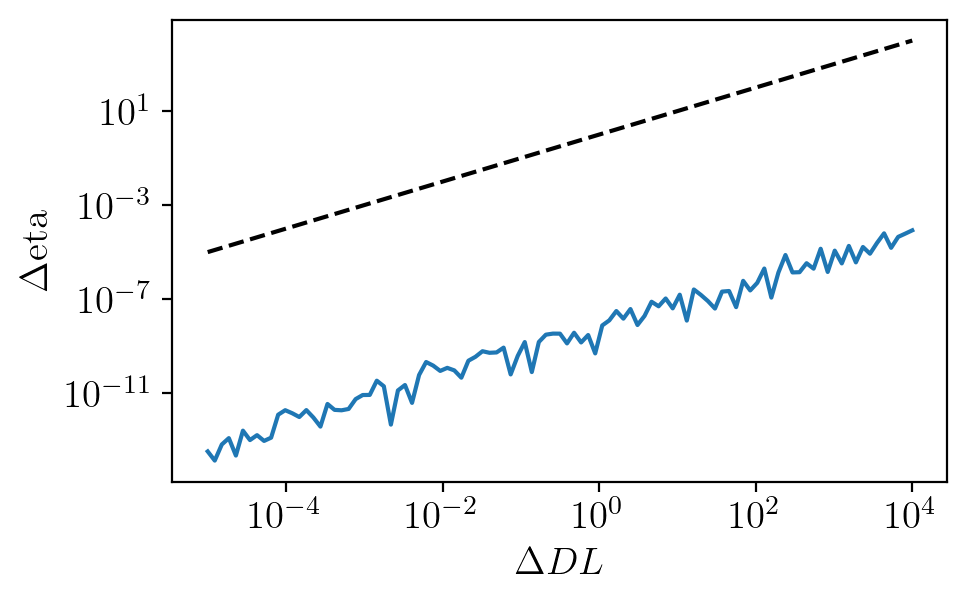

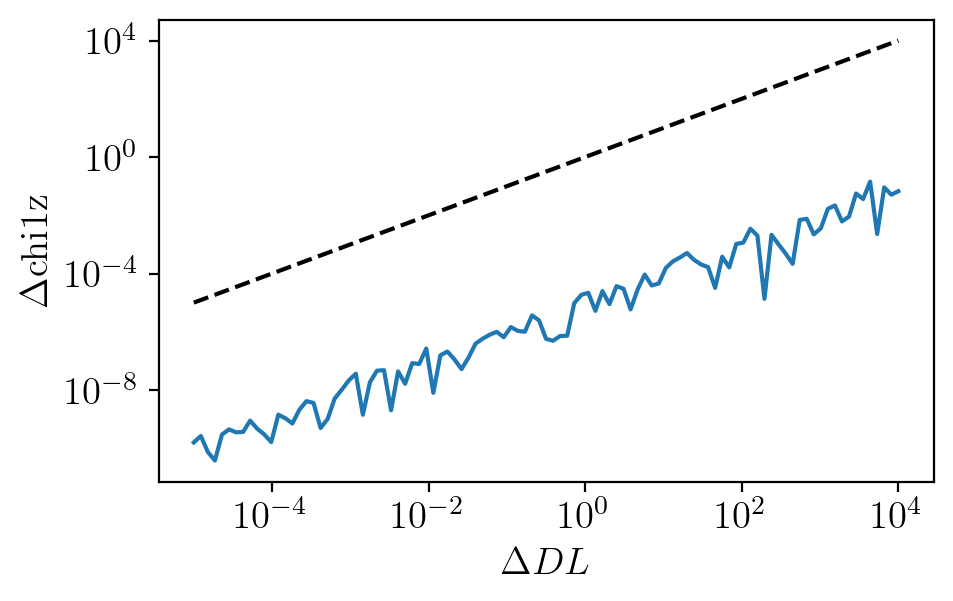

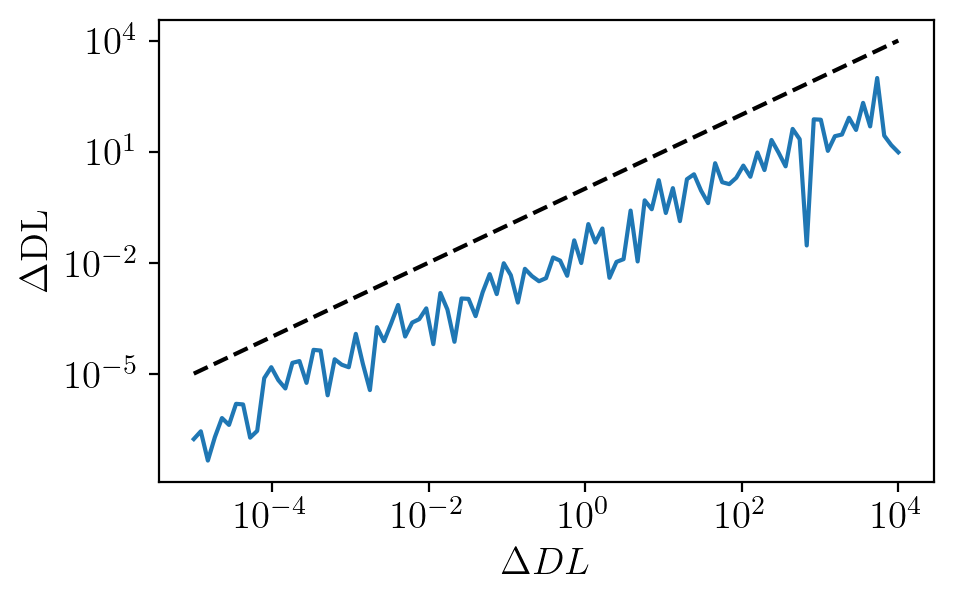

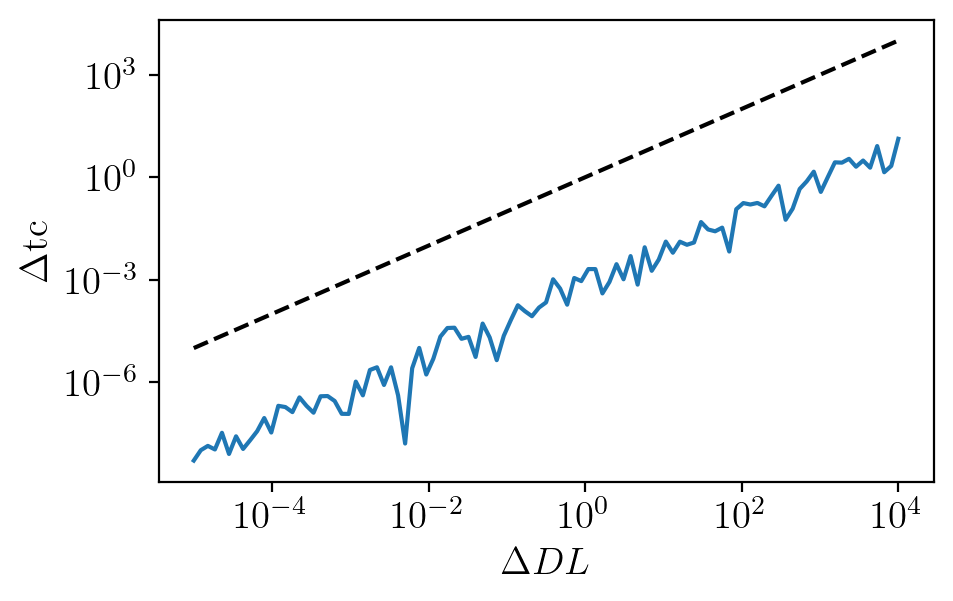

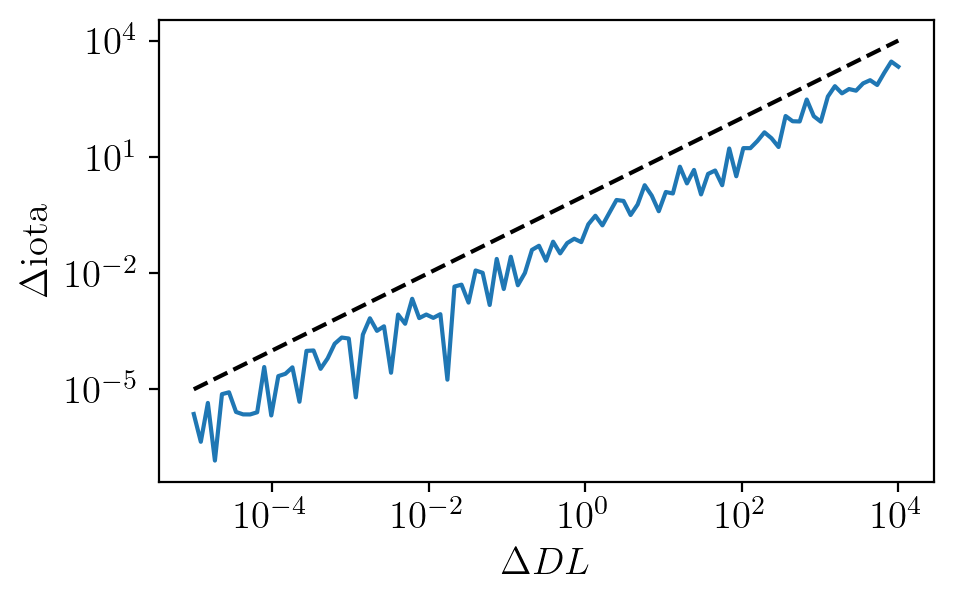

In [215]:
for var in ['Mc', 'eta', 'chi1z', 'DL', 'tc', 'iota']:
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
    var_index = net_opt.deriv_variables.index(var)
    plt.plot(DL_range, np.abs(cv_biases[:,var_index]))
    plt.plot(DL_range, DL_range, ls='--', color='k')
    plt.loglog()
    plt.xlabel('$\Delta DL$')
    plt.ylabel('$\Delta$' + var)
    plt.show()

This is a problem. Biasing DL should not really affect any other parameter (except iota). It should definitely not impact parameters that only enter the phase (like eta and chi1, chi2)

### How does the waveform (mismatch) change with DL?

Luminosity distance only affects the normalization, so the mismatch is completely agniostic to it. That's why I have to switch to unnormalized waveforms here.

In [78]:
i = 47519 # 'Pessimistic' Binary

net_key = '3G'
approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomXAS'

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 


d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_1 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_spec = ['CE-40_C'], calc_detector_responses=True)

delta_f = net_1.f[1] - net_1.f[0]
psd = FrequencySeries(net_1.detectors[0].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

# make sure that the detector and waveform frequency ranges overlap
freq_mask = np.in1d(net_1.f, net_1.detectors[0].f, assume_unique=True)

hp1_pyc = FrequencySeries(net_1.hfp[freq_mask], delta_f=delta_f)
hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) / psd).data)

N = 11
DL_range = np.geomspace(1e0, 1e8, N)
overlaps = np.zeros(N)
hp2_set = np.zeros((N, len(net_1.hfp)))

for i in tqdm(range(N)):
    inj_params_opt = inj_params.copy()
    inj_params_opt['DL'] += DL_range[i]

    # compute CV biases after aligning the waveforms
    net_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_spec = ['CE-40_C'], f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)

    hp2_pyc = FrequencySeries(net_opt.hfp[freq_mask], delta_f=delta_f)
    hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

    hp2_set[i] = net_opt.hfp

    # overlaps[i] = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm)) # match
    overlaps[i] = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) # Not normalized, to see the effects of DL


2023-11-28 14:09:36,778 - Network - INFO : Polarizations calculated.
2023-11-28 14:09:36,779 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-28 14:09:36,783 - Network - INFO : Polarizations calculated.


2023-11-28 14:09:37,422 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-28 14:09:37,432 - Network - INFO : PSDs loaded.
2023-11-28 14:09:37,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-28 14:09:37,437 - Network - INFO : Detector responses calculated.
2023-11-28 14:09:37,437 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-28 14:09:37,438 - Network - INFO :    CE-40_C
2023-11-28 14:09:37,875 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-28 14:09:37,877 - Network - INFO : SNRs calculated.
2023-11-28 14:09:37,878 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-28 14:09:37,878 - Network - INFO :    CE-40_C
2023-11-28 14:09:37,970 - Network - INFO : Errors calculated.
  0%|          | 0/11 [00:00<?, ?it/s]2023-11-28 14:09:37,983 - Network - INFO : Polarizations calculated.
2023-11-28 14:09:37,983 - Network - INFO : Calculate numeric derivatives of polarizati

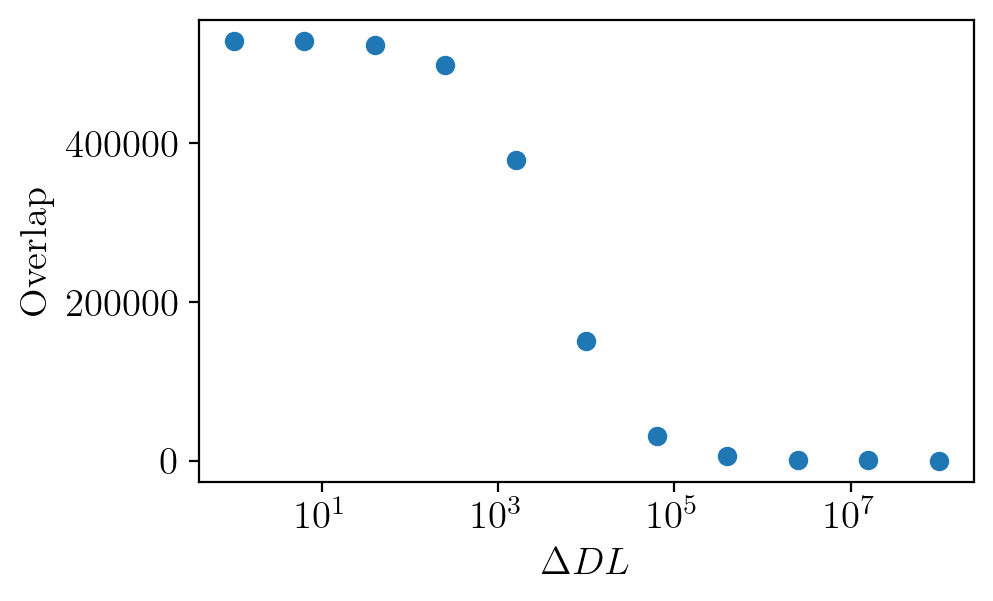

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


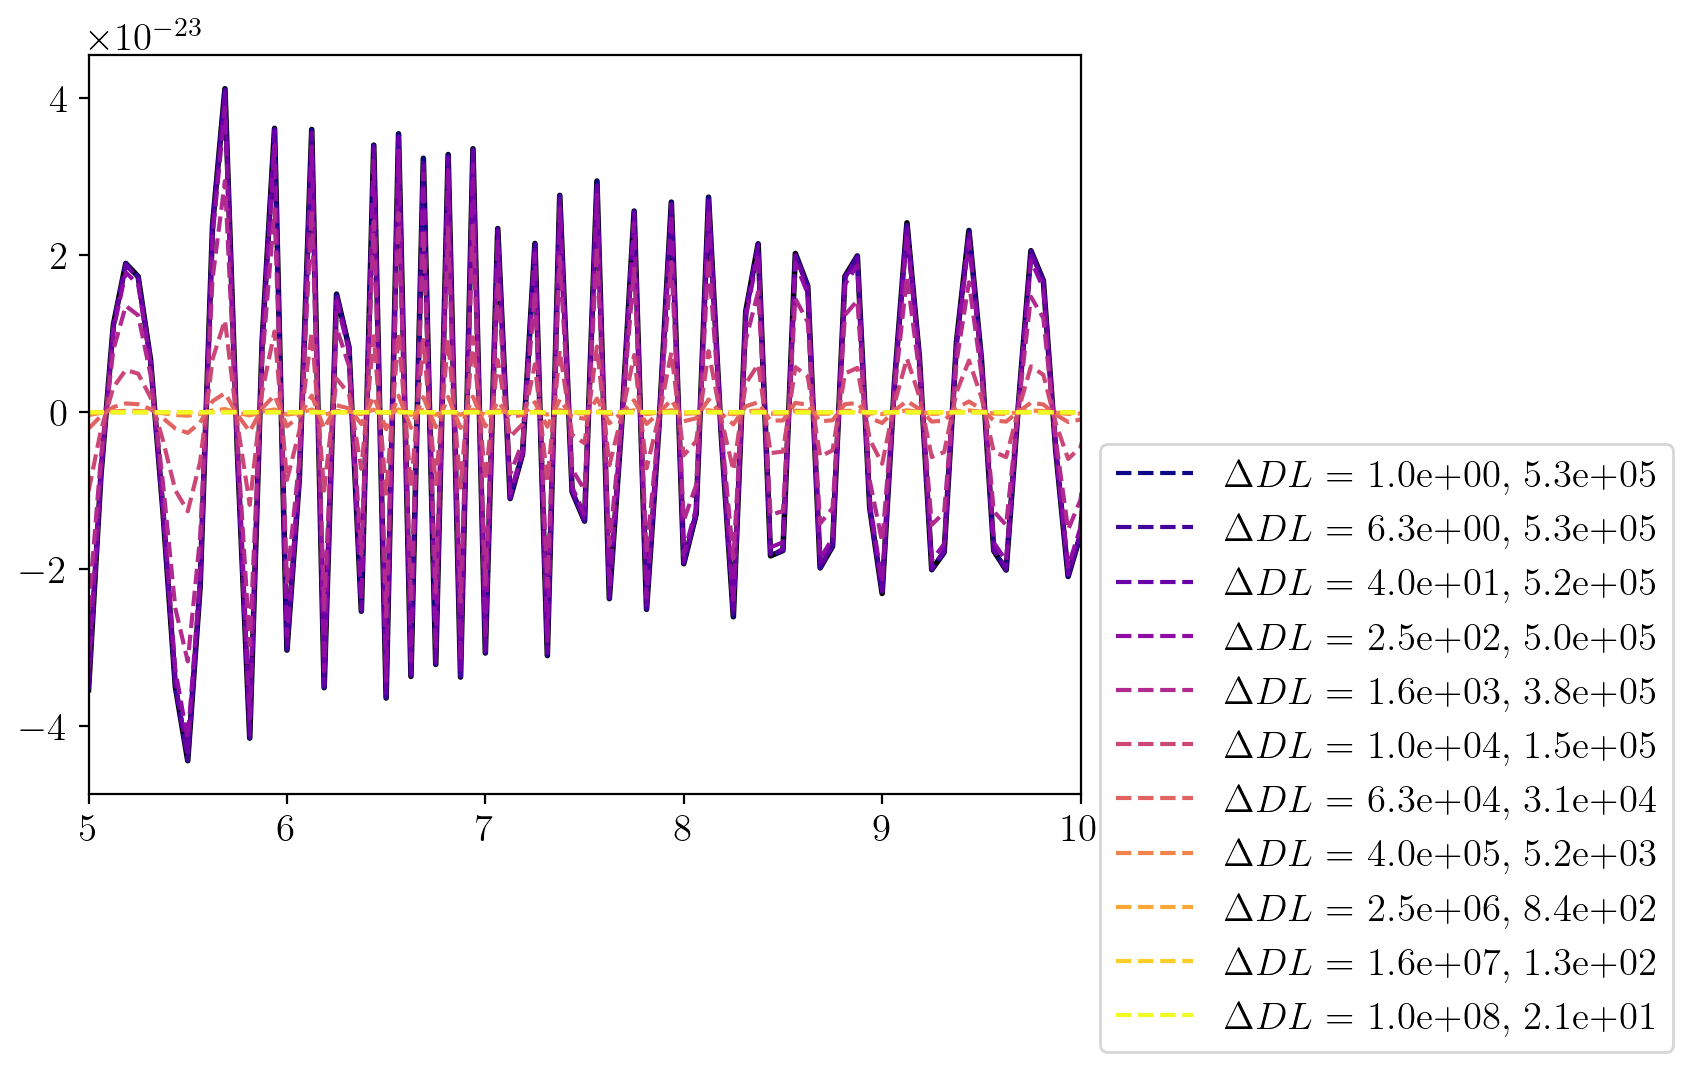

In [83]:
import matplotlib.cm as cm
colors = cm.plasma(np.linspace(0, 1, N))

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
plt.scatter(DL_range, overlaps)
plt.semilogx()
plt.xlabel('$\Delta DL$')
plt.ylabel('Overlap')
plt.show()



plt.plot(net_1.f, net_1.hfp, color='k', lw=2)

for i in range(N):
    plt.plot(net_1.f, hp2_set[i], label=f'$\Delta DL$ = {DL_range[i]:.1e}, {overlaps[i]:.1e}', color=colors[i], ls='--')

plt.legend(bbox_to_anchor=(1,0.5))
plt.xlim(5, 10)
plt.show()

In [167]:
# DL_index = net_opt.deriv_variables.index('DL')

# for i in range(len(net_opt.deriv_variables)):
#     print(net_opt.deriv_variables[i], net_opt.cov[i,DL_index])





# net_opt.detectors[0].cov
print(net_opt.detectors[0].cov[:,4])

[[ 3.30589682e-01]
 [-1.34051156e+00]
 [ 1.25556763e+03]
 [-1.29045935e+03]
 [ 4.32768240e+07]
 [ 1.70643005e+02]
 [ 3.12822312e+05]
 [ 1.79576953e+05]
 [-1.25532836e+05]
 [-6.81928203e+04]
 [ 1.90553719e+05]]


In [164]:
import gwbench.utils as gwbench_utils
import gwbench.snr as snr_mod

del_hf_sub_dict = gwbench_utils.get_sub_dict(net_opt.detectors[0].del_hf,('hf',),0)
del_hf_list = list(del_hf_sub_dict.values())
n = len(del_hf_list)
fisher = np.zeros((n,n))

for i in np.arange(n):
    fisher[i,i] = snr_mod.scalar_product_freq_array(del_hf_list[i], del_hf_list[i], net_opt.detectors[0].psd, net_opt.detectors[0].f)
    for j in np.arange(i+1,n):
        fisher[i,j] = snr_mod.scalar_product_freq_array(del_hf_list[i], del_hf_list[j], net_opt.detectors[0].psd, net_opt.detectors[0].f)
        fisher[j,i] = fisher[i,j]
np.linalg.inv(fisher)[:,4]

array([ 3.30589719e-01, -1.34051267e+00,  1.25556865e+03, -1.29046037e+03,
        4.32768228e+07,  1.70676920e+02,  3.12820405e+05,  1.79573723e+05,
       -1.25530766e+05, -6.81936790e+04,  1.90550945e+05])